Características del Modelo LeNetOverfit
🏗️ Arquitectura CNN
Capas Convolucionales:

4 capas convolucionales progresivas:

conv1: 3 → 64 canales (kernel 3x3, padding 1)

conv2: 64 → 128 canales (kernel 3x3, padding 1)

conv3: 128 → 256 canales (kernel 3x3, padding 1)

conv4: 256 → 256 canales (kernel 3x3, padding 1)

Características de Capas:

Batch Normalization después de cada convolución

MaxPooling (2x2) después de cada capa → reduce tamaño espacial 16x

Activación ReLU en todas las capas

Dropout del 20% en capas fully connected

In [5]:
# ============================================================
# Script para organizar imágenes del UYES dataset
# ============================================================

import os
import pandas as pd
import shutil

# 1. Ruta del CSV y de las imágenes
csv_path = "./UEyes_dataset/image_types.csv"  # cámbialo por la ruta real de tu CSV
images_dir = "./UEyes_dataset/images"  # carpeta donde están todas las imágenes
output_dir = "dataset_split"  # carpeta de salida organizada

# 2. Leer el CSV (separador ;)
df = pd.read_csv(csv_path, sep=";")

# 3. Crear carpetas destino y copiar imágenes
for _, row in df.iterrows():
    img_name = row["Image Name"]
    category = row["Category"]
    split = row["Train/Test"]  # Train o Test

    # Construir ruta de destino: dataset_split/Train/desktop/2021b7.png
    dest_dir = os.path.join(output_dir, split, category)
    os.makedirs(dest_dir, exist_ok=True)

    # Ruta de origen y destino
    src_path = os.path.join(images_dir, img_name)
    dst_path = os.path.join(dest_dir, img_name)

    # Copiar archivo si existe
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"⚠️ Imagen no encontrada: {src_path}")

print("✅ Organización completada.")


✅ Organización completada.


In [6]:
# =========================
# 1) Setup y dependencias
# =========================
import os, random, math, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Configuración reproducible
SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Selección de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("⚠️ MPS no disponible porque la instalación de PyTorch no fue compilada con soporte MPS.")
        device = torch.device("mps")
    else:
        print("⚠️ MPS no disponible porque tu macOS no es 12.3+ o tu hardware no soporta MPS.")
else:
    print("✅ MPS está disponible y listo para usar.")


⚠️ MPS no disponible porque la instalación de PyTorch no fue compilada con soporte MPS.


In [8]:
# =========================
# 2) Rutas y transformaciones
# =========================
DATA_ROOT = Path("dataset_split")  # ajusta si usaste otro nombre
TRAIN_DIR = DATA_ROOT / "Train"
TEST_DIR  = DATA_ROOT / "Test"

IMG_SIZE = 224
BATCH_SIZE = 128

# Si las imágenes son grises, las convertimos a 3 canales.
# Normalización estilo ImageNet (válida para iniciar).
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Para validación/test usamos mismas transformaciones (sin augment agresivo).
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
# =========================
# 3) Datasets y DataLoaders
# =========================
train_ds_full = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
test_ds = datasets.ImageFolder(root=str(TEST_DIR), transform=test_tfms)

# Split: del conjunto de entrenamiento, 20% para validación
val_ratio = 0.20
n_total = len(train_ds_full)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_ds, val_ds = random_split(train_ds_full, [n_train, n_val],
generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_names = train_ds_full.classes
num_classes = len(class_names)
print("Clases:", class_names, "| #Train:", len(train_ds), "| #Val:", len(val_ds), "| #Test:", len(test_ds))

Clases: ['desktop', 'mobile', 'poster', 'web'] | #Train: 1498 | #Val: 374 | #Test: 108


MODELO 87% YA GUARDADO EN LENET_OVERFIT_BEST.PT

SI NECESITAN USARLO, SOLAMENTE DEBEN UTILIZAR EL CHECKPOINT DE LA SIGUIENTE CELDA

⚠️ Usando CPU (ni CUDA ni MPS disponibles)
✅ Modelo sobreajustado creado en: cpu
[001/30] train_loss=1.9058 acc=0.435 | val_loss=1.4751 acc=0.444 | 722.8s
🔄 Learning Rate actual: 0.000100
 ✓ Nuevo mejor modelo guardado (0.444) -> lenet_overfit_best.pt
[002/30] train_loss=0.8528 acc=0.679 | val_loss=0.8296 acc=0.658 | 675.4s
🔄 Learning Rate actual: 0.000100
 ✓ Nuevo mejor modelo guardado (0.658) -> lenet_overfit_best.pt
[003/30] train_loss=0.6372 acc=0.753 | val_loss=0.5902 acc=0.754 | 690.7s
🔄 Learning Rate actual: 0.000100
 ✓ Nuevo mejor modelo guardado (0.754) -> lenet_overfit_best.pt
[004/30] train_loss=0.4684 acc=0.807 | val_loss=0.5642 acc=0.786 | 677.0s
🔄 Learning Rate actual: 0.000100
 ✓ Nuevo mejor modelo guardado (0.786) -> lenet_overfit_best.pt
[005/30] train_loss=0.3583 acc=0.860 | val_loss=0.4856 acc=0.807 | 580.6s
🔄 Learning Rate actual: 0.000100
 ✓ Nuevo mejor modelo guardado (0.807) -> lenet_overfit_best.pt
[006/30] train_loss=0.3031 acc=0.886 | val_loss=0.5037 acc=0.805

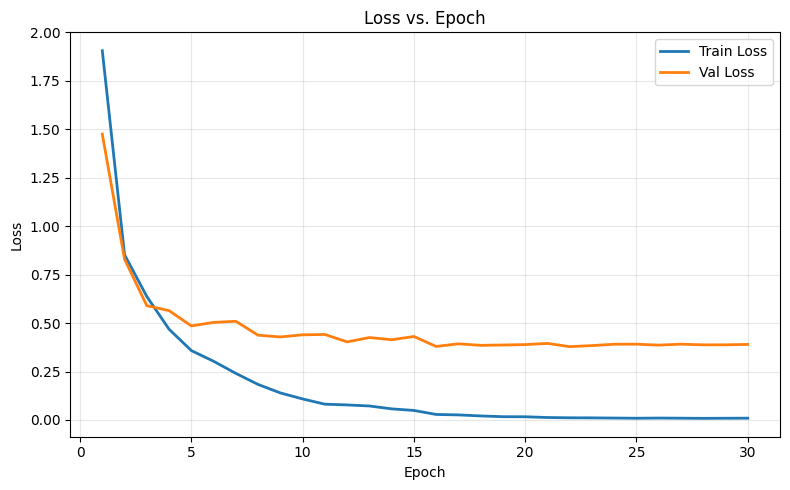

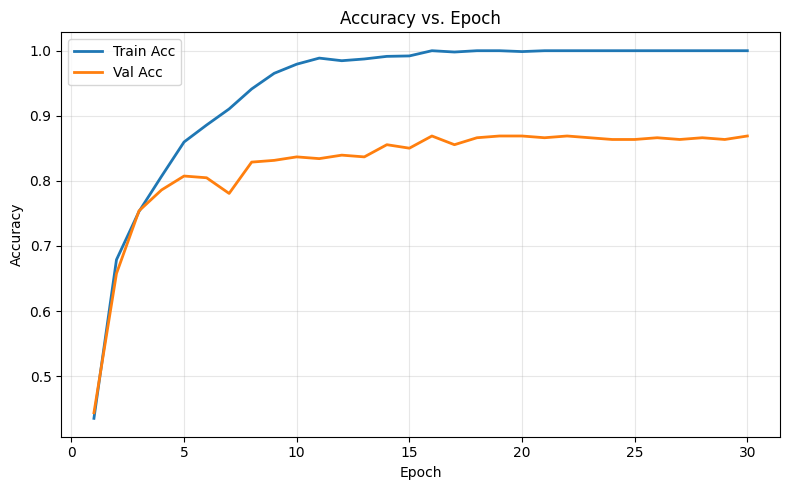

In [ ]:
# =========================
# 1) Selección del dispositivo
# =========================
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Usando CUDA")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Usando MPS")
else:
    device = torch.device("cpu")
    print("⚠️ Usando CPU (ni CUDA ni MPS disponibles)")

# =========================
# 2) Definición del modelo CNN sobreajustado
# =========================
class LeNetOverfit(nn.Module):
    def __init__(self, num_classes, img_size):
        super(LeNetOverfit, self).__init__()
        # Justificación:
        # - Más filtros y capas para mayor capacidad de ajuste.
        # - Dropout reducido para permitir sobreajuste.
        # - BatchNorm para estabilidad.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        # Calcular automáticamente el tamaño para fc1
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            out = self.pool(F.relu(self.conv4(out)))
            flat_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# =========================
# 3) Crear modelo
# =========================
# Asegúrate de definir num_classes y IMG_SIZE antes de este bloque
model = LeNetOverfit(num_classes=num_classes, img_size=IMG_SIZE).to(device)
print("✅ Modelo sobreajustado creado en:", device)

# =========================
# 4) Entrenamiento + Historial
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# =========================
# 5) Loop de entrenamiento (más épocas)
# =========================
EPOCHS = 30  # Aumenta el número de épocas para sobreajuste
best_val_acc = 0.0
save_path = "lenet_overfit_best.pt"
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    dt = time.time() - t0
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    print(f"[{epoch:03d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f} acc={train_acc:.3f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.3f} | {dt:.1f}s")
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"🔄 Learning Rate actual: {current_lr:.6f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "classes": class_names,
            "img_size": IMG_SIZE
        }, save_path)
        print(f" ✓ Nuevo mejor modelo guardado ({best_val_acc:.3f}) -> {save_path}")

print("✅ Entrenamiento finalizado (sobreajuste).")

# =========================
# 6) Gráficas
# =========================
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(epochs_range, history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history["train_acc"], label="Train Acc", linewidth=2)
plt.plot(epochs_range, history["val_acc"], label="Val Acc", linewidth=2)
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=150)
plt.show()

CHECKPOINT PARA CARGAR EL MODELO

Este código extrae solo la parte esencial para cargar el checkpoint, incluyendo:

Carga del checkpoint con torch.load()

Análisis de la estructura del modelo guardado

Definición de la arquitectura LeNetOverfit

Carga de pesos en el modelo

Configuración del modelo en modo evaluación

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------
# CARGAR CHECKPOINT DEL MODELO
# ------------------------------
checkpoint = torch.load("lenet_overfit_best.pt", map_location="cpu")

print("🔍 Información del checkpoint:")
print("   - Clases declaradas:", checkpoint["classes"])
print("   - Número de clases declaradas:", len(checkpoint["classes"]))
print("   - Shape de fc2.weight:", checkpoint["model_state"]["fc2.weight"].shape)
print("   - Número REAL de clases según pesos:", checkpoint["model_state"]["fc2.weight"].shape[0])

# El modelo fue guardado con 10 clases, pero solo tenemos 4 clases reales
real_num_classes = checkpoint["model_state"]["fc2.weight"].shape[0]  # 10
declared_classes = checkpoint["classes"]  # 4 clases

print(f"   ⚠️  INCONSISTENCIA: Modelo guardado con {real_num_classes} clases, pero declaradas {len(declared_classes)} clases")

# Arquitectura del modelo
class LeNetOverfit(nn.Module):
    def __init__(self, num_classes, img_size):
        super(LeNetOverfit, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            out = self.pool(F.relu(self.conv4(out)))
            flat_dim = out.view(1, -1).shape[1]
        
        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo con el número correcto de clases (10)
model = LeNetOverfit(num_classes=real_num_classes, img_size=checkpoint["img_size"]).to(device)

# Cargar los pesos del checkpoint
model.load_state_dict(checkpoint["model_state"])
model.eval()

print("✅ Modelo cargado CORRECTAMENTE")
print(f"   - Número de clases del modelo: {real_num_classes}")
print(f"   - Clases declaradas en checkpoint: {declared_classes}")
print(f"   - Dispositivo: {device}")

🔍 Información del checkpoint:
   - Clases declaradas: ['desktop', 'mobile', 'poster', 'web']
   - Número de clases declaradas: 4
   - Shape de fc2.weight: torch.Size([10, 512])
   - Número REAL de clases según pesos: 10
   ⚠️  INCONSISTENCIA: Modelo guardado con 10 clases, pero declaradas 4 clases
✅ Modelo cargado CORRECTAMENTE
   - Número de clases del modelo: 10
   - Clases declaradas en checkpoint: ['desktop', 'mobile', 'poster', 'web']
   - Dispositivo: cpu


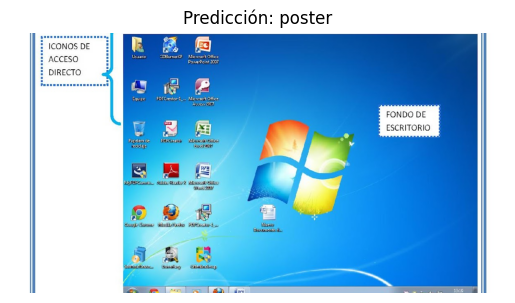

In [ ]:
# ------------------------------
# 8. Subir y evaluar una imagen externa
# ------------------------------
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Usar el tamaño original del entrenamiento
img_size = checkpoint["img_size"]

transform_single = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Ruta de la imagen
ruta_imagen = "maxresdefault.jpg"

# Abrir y transformar
imagen = Image.open(ruta_imagen).convert("RGB")
entrada = transform_single(imagen).unsqueeze(0)  # añadir dimensión batch

# Evaluar con el modelo
net.eval()
with torch.no_grad():
    salida = net(entrada)
    _, prediccion = torch.max(salida, 1)

# Mostrar resultado
plt.imshow(imagen)
plt.title(f"Predicción: {classes[prediccion.item()]}")
plt.axis("off")
plt.show()


CODIGO PROPORCIONADO POR EL PROFESOR EL 17/09/2025

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def denormalize(t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    t: [C,H,W] en torch (normalizado). Devuelve numpy [H,W,C] en [0,1]
    """
    x = t.detach().cpu().clone()
    for c in range(3):
        x[c] = x[c] * std[c] + mean[c]
    x = x.clamp(0, 1)
    return x.permute(1,2,0).numpy()

def show_image_and_heatmap(rgb_img_np, heatmap_np, alpha=0.35):
    """
    rgb_img_np: [H,W,C] en [0,1]
    heatmap_np: [H,W] en [0,1]
    """
    H, W = heatmap_np.shape
    fig = plt.figure(figsize=(10,4))
    # original
    ax1 = plt.subplot(1,3,1)
    ax1.imshow(rgb_img_np)
    ax1.set_title("Imagen")
    ax1.axis("off")
    # heatmap
    ax2 = plt.subplot(1,3,2)
    ax2.imshow(heatmap_np, cmap="jet")
    ax2.set_title("Grad-CAM")
    ax2.axis("off")
    # overlay
    ax3 = plt.subplot(1,3,3)
    ax3.imshow(rgb_img_np)
    ax3.imshow(heatmap_np, cmap="jet", alpha=alpha)
    ax3.set_title("Overlay")
    ax3.axis("off")
    plt.tight_layout()
    plt.show()

🔍 Información del checkpoint:
   - Clases declaradas: ['desktop', 'mobile', 'poster', 'web']
   - Número de clases declaradas: 4
   - Shape de fc2.weight: torch.Size([10, 512])
   - Número REAL de clases según pesos: 10
   ⚠️  INCONSISTENCIA: Modelo guardado con 10 clases, pero declaradas 4 clases
✅ Modelo cargado CORRECTAMENTE
   - Número de clases del modelo: 10
   - Clases declaradas en checkpoint: ['desktop', 'mobile', 'poster', 'web']
   - Tamaño de imagen: 224
   - Dispositivo: cpu

🚀 Ejecutando explicación con modelo corregido...
🎯 Predicción (4 clases): poster (99.08%)
🔍 Predicción original (10 clases): Clase 2 (99.08%)


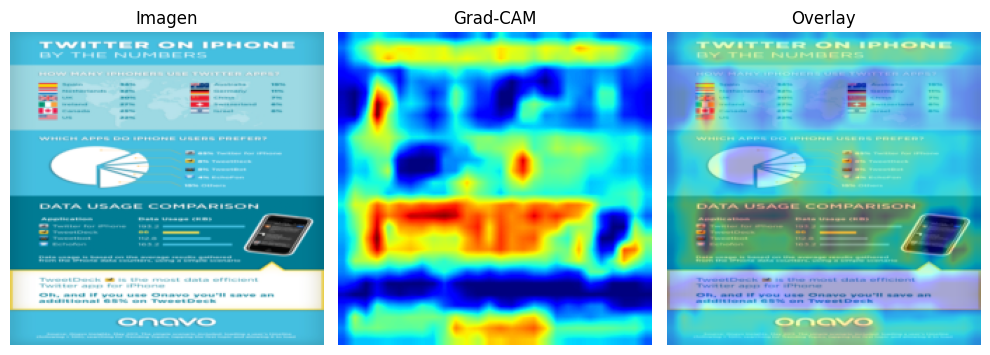

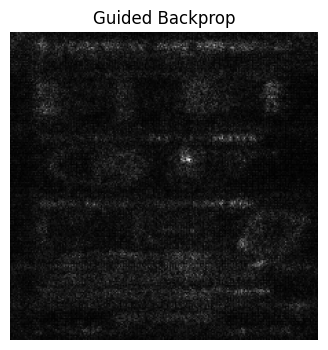

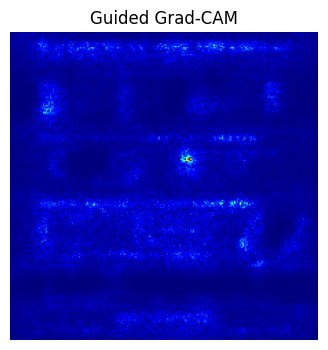

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ------------------------------
# 1. Cargar el modelo CON LA ARQUITECTURA CORRECTA
# ------------------------------

# Usar EXACTAMENTE la misma arquitectura que en entrenamiento
class LeNetOverfit(nn.Module):
    def __init__(self, num_classes, img_size):
        super(LeNetOverfit, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            out = self.pool(F.relu(self.conv4(out)))
            flat_dim = out.view(1, -1).shape[1]
        
        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Cargar checkpoint CORRECTO
checkpoint = torch.load("lenet_overfit_best.pt", map_location="cpu")

print("🔍 Información del checkpoint:")
print("   - Clases declaradas:", checkpoint["classes"])
print("   - Número de clases declaradas:", len(checkpoint["classes"]))
print("   - Shape de fc2.weight:", checkpoint["model_state"]["fc2.weight"].shape)
print("   - Número REAL de clases según pesos:", checkpoint["model_state"]["fc2.weight"].shape[0])

# El modelo fue guardado con 10 clases, pero solo tenemos 4 clases reales
real_num_classes = checkpoint["model_state"]["fc2.weight"].shape[0]  # 10
declared_classes = checkpoint["classes"]  # 4 clases
img_size = checkpoint["img_size"]

print(f"   ⚠️  INCONSISTENCIA: Modelo guardado con {real_num_classes} clases, pero declaradas {len(declared_classes)} clases")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo con el número correcto de clases (10)
model = LeNetOverfit(num_classes=real_num_classes, img_size=img_size).to(device)

# Cargar los pesos del checkpoint
model.load_state_dict(checkpoint["model_state"])
model.eval()

print("✅ Modelo cargado CORRECTAMENTE")
print(f"   - Número de clases del modelo: {real_num_classes}")
print(f"   - Clases declaradas en checkpoint: {declared_classes}")
print(f"   - Tamaño de imagen: {img_size}")
print(f"   - Dispositivo: {device}")

# Mapeo de clases para usar solo las 4 clases relevantes
class_mapping = {
    0: 'desktop',    # Primera clase del modelo -> desktop
    1: 'mobile',     # Segunda clase del modelo -> mobile  
    2: 'poster',     # Tercera clase del modelo -> poster
    3: 'web',        # Cuarta clase del modelo -> web
}
class_names = ['desktop', 'mobile', 'poster', 'web']

# ------------------------------
# 2. Definir constantes y funciones auxiliares
# ------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def denormalize(t: torch.Tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    t: [C,H,W] en torch (normalizado). Devuelve numpy [H,W,C] en [0,1]
    """
    x = t.detach().cpu().clone()
    for c in range(3):
        x[c] = x[c] * std[c] + mean[c]
    x = x.clamp(0, 1)
    return x.permute(1,2,0).numpy()

def show_image_and_heatmap(rgb_img_np, heatmap_np, alpha=0.35):
    """
    rgb_img_np: [H,W,C] en [0,1]
    heatmap_np: [H,W] en [0,1]
    """
    H, W = heatmap_np.shape
    fig = plt.figure(figsize=(10,4))
    # original
    ax1 = plt.subplot(1,3,1)
    ax1.imshow(rgb_img_np)
    ax1.set_title("Imagen")
    ax1.axis("off")
    # heatmap
    ax2 = plt.subplot(1,3,2)
    ax2.imshow(heatmap_np, cmap="jet")
    ax2.set_title("Grad-CAM")
    ax2.axis("off")
    # overlay
    ax3 = plt.subplot(1,3,3)
    ax3.imshow(rgb_img_np)
    ax3.imshow(heatmap_np, cmap="jet", alpha=alpha)
    ax3.set_title("Overlay")
    ax3.axis("off")
    plt.tight_layout()
    plt.show()

# ------------------------------
# 3. Transformaciones y configuración
# ------------------------------
IMG_SIZE = img_size  # Usar el tamaño del checkpoint

infer_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ------------------------------
# 4. Implementación de Grad-CAM
# ------------------------------
class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.fwd_handle = self.target_layer.register_forward_hook(fwd_hook)
        self.bwd_handle = self.target_layer.register_full_backward_hook(bwd_hook)

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

    @torch.no_grad()
    def _normalize_cam(self, cam):
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

    def generate(self, x: torch.Tensor, class_idx: int = None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        
        # Mapear clase si es necesario
        if class_idx is not None and class_idx >= len(class_names):
            # Si la clase está fuera del rango de nuestras 4 clases, mapear
            probs = torch.softmax(logits, dim=1)
            class_idx = torch.argmax(probs[0, :4]).item()
        elif class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).item())
            # Si la predicción está fuera del rango, mapear a las 4 clases
            if class_idx not in class_mapping:
                probs = torch.softmax(logits, dim=1)
                class_idx = torch.argmax(probs[0, :4]).item()

        one_hot = torch.zeros_like(logits)
        one_hot[0, class_idx] = 1.0
        logits.backward(gradient=one_hot, retain_graph=True)

        acts = self.activations[0]
        grads = self.gradients[0]

        weights = grads.mean(dim=(1,2))
        cam = torch.zeros_like(acts[0])
        for c, w in enumerate(weights):
            cam += w * acts[c]

        cam = F.relu(cam)
        cam = self._normalize_cam(cam)

        cam = cam.unsqueeze(0).unsqueeze(0)
        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        cam = cam[0,0].cpu().numpy()
        return cam, class_idx

# Seleccionar la capa objetivo (última capa convolucional - CONV4)
target_conv = model.conv4  # CORREGIDO: usar conv4 en lugar de conv3
gradcam = GradCAM(model, target_conv)

# ------------------------------
# 5. Guided Backpropagation
# ------------------------------
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.relu(input)

    @staticmethod
    def backward(ctx, grad_output):
        (inp,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[grad_output < 0] = 0
        grad_input[inp < 0] = 0
        return grad_input

class GuidedReLU(torch.nn.Module):
    def forward(self, x):
        return GuidedBackpropReLU.apply(x)

def replace_relu_with_guided(module: torch.nn.Module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.ReLU):
            setattr(module, name, GuidedReLU())
        else:
            replace_relu_with_guided(child)

# Crear modelo guiado con la misma arquitectura
guided_model = LeNetOverfit(num_classes=real_num_classes, img_size=img_size).to(device)
guided_model.load_state_dict(checkpoint["model_state"])
guided_model.eval()
replace_relu_with_guided(guided_model)

def guided_backprop(guided_model: torch.nn.Module, x: torch.Tensor, class_idx: int = None):
    guided_model.zero_grad(set_to_none=True)
    x = x.clone().detach().requires_grad_(True)

    logits = guided_model(x)
    
    # Mapear clase si es necesario
    if class_idx is not None and class_idx >= len(class_names):
        probs = torch.softmax(logits, dim=1)
        class_idx = torch.argmax(probs[0, :4]).item()
    elif class_idx is None:
        class_idx = int(torch.argmax(logits, dim=1).item())
        if class_idx not in class_mapping:
            probs = torch.softmax(logits, dim=1)
            class_idx = torch.argmax(probs[0, :4]).item()

    one_hot = torch.zeros_like(logits)
    one_hot[0, class_idx] = 1.0
    logits.backward(gradient=one_hot)

    saliency = x.grad.detach()[0]
    saliency = saliency.abs().max(dim=0)[0]
    saliency -= saliency.min()
    saliency /= (saliency.max() + 1e-8)
    return saliency.cpu().numpy(), class_idx

def guided_gradcam(gradcam_map: np.ndarray, guided_bp_map: np.ndarray):
    ggc = gradcam_map * guided_bp_map
    ggc = ggc - ggc.min()
    ggc = ggc / (ggc.max() + 1e-8)
    return ggc

# ------------------------------
# 6. Función principal para explicaciones
# ------------------------------
def run_explain(image_path: str, alpha_overlay=0.35):
    # 1) Cargar imagen y tensorear
    pil = Image.open(image_path).convert("RGB")  # Asegurar que es RGB
    x = infer_tfms(pil).unsqueeze(0).to(device)

    # 2) Predicción con mapeo a 4 clases
    model.eval()
    with torch.no_grad():
        logits = model(x)
        
        # Mapear de 10 clases a 4 clases
        probs_10 = torch.softmax(logits, dim=1)[0].cpu().numpy()
        probs_4 = probs_10[:4]  # Tomar solo las primeras 4 clases
        probs_4 = probs_4 / probs_4.sum()  # Renormalizar
        
        pred_idx_4 = int(np.argmax(probs_4))
        pred_cls = class_names[pred_idx_4]
        pred_prob = float(probs_4[pred_idx_4])
        
        # También mostrar la predicción original de 10 clases
        pred_idx_10 = int(np.argmax(probs_10))
        pred_prob_10 = float(probs_10[pred_idx_10])

    print(f"🎯 Predicción (4 clases): {pred_cls} ({pred_prob:.2%})")
    print(f"🔍 Predicción original (10 clases): Clase {pred_idx_10} ({pred_prob_10:.2%})")
    if pred_idx_10 >= len(class_names):
        print(f"⚠️  La predicción original está fuera del rango de las 4 clases")

    # 3) Grad-CAM (usar la clase mapeada de 4 clases)
    cam, cam_class_idx = gradcam.generate(x, class_idx=pred_idx_4)

    # 4) Guided Backprop
    gbp, _ = guided_backprop(guided_model, x, class_idx=pred_idx_4)

    # 5) Guided Grad-CAM
    ggc = guided_gradcam(cam, gbp)

    # 6) Mostrar resultados
    rgb_np = denormalize(x[0])
    show_image_and_heatmap(rgb_np, cam, alpha=alpha_overlay)

    # Guided Backprop solo
    plt.figure(figsize=(5,4))
    plt.imshow(gbp, cmap="gray")
    plt.title("Guided Backprop")
    plt.axis("off")
    plt.show()

    # Guided Grad-CAM
    plt.figure(figsize=(5,4))
    plt.imshow(ggc, cmap="jet")
    plt.title("Guided Grad-CAM")
    plt.axis("off")
    plt.show()

# ------------------------------
# 7. Ejecutar ejemplo
# ------------------------------
# Ejemplo:
print("\n" + "="*50)
print("🚀 Ejecutando explicación con modelo corregido...")
print("="*50)
run_explain("./dataset_split/Test/poster/ab0c83.png")

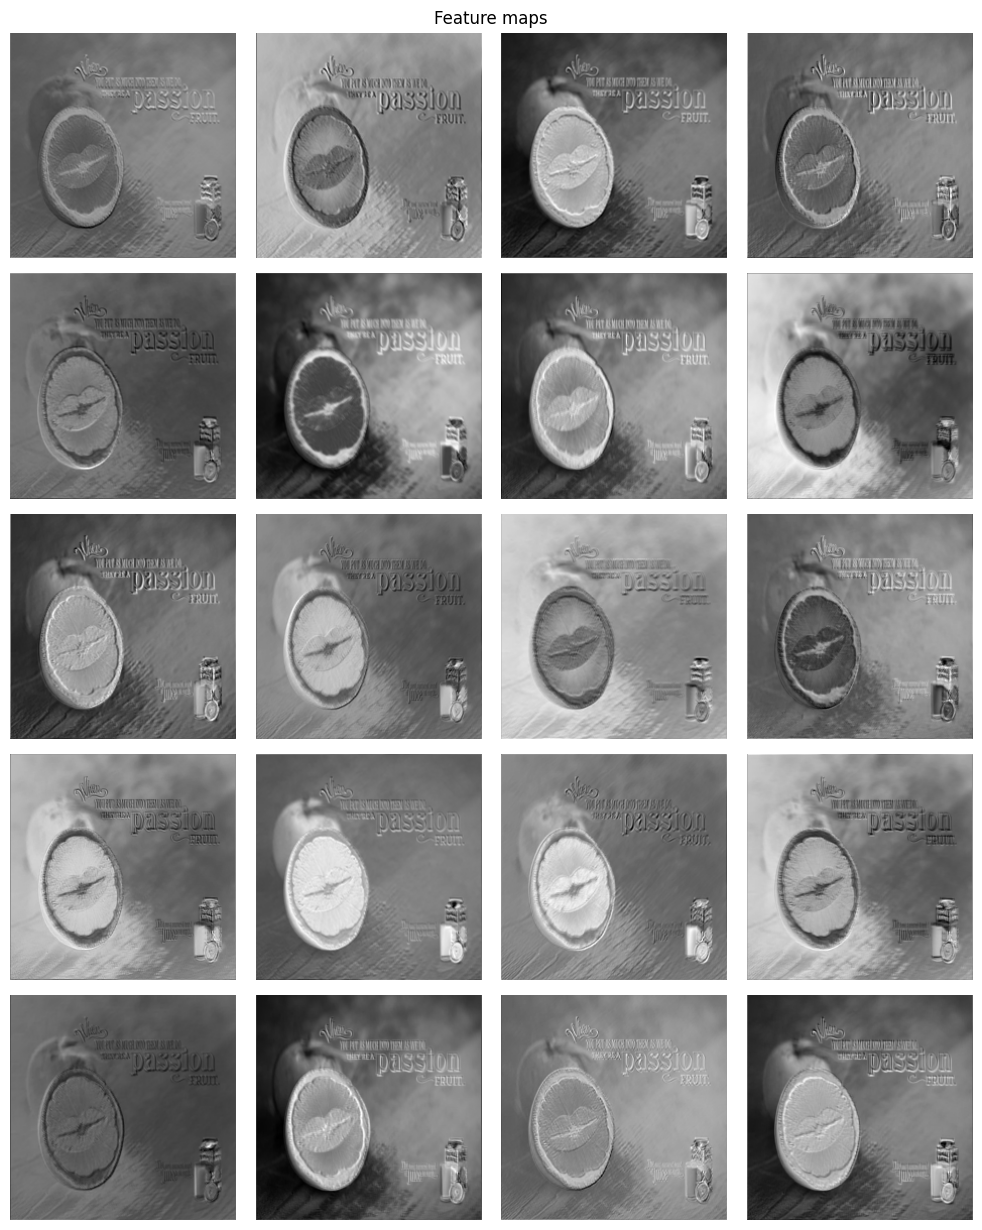

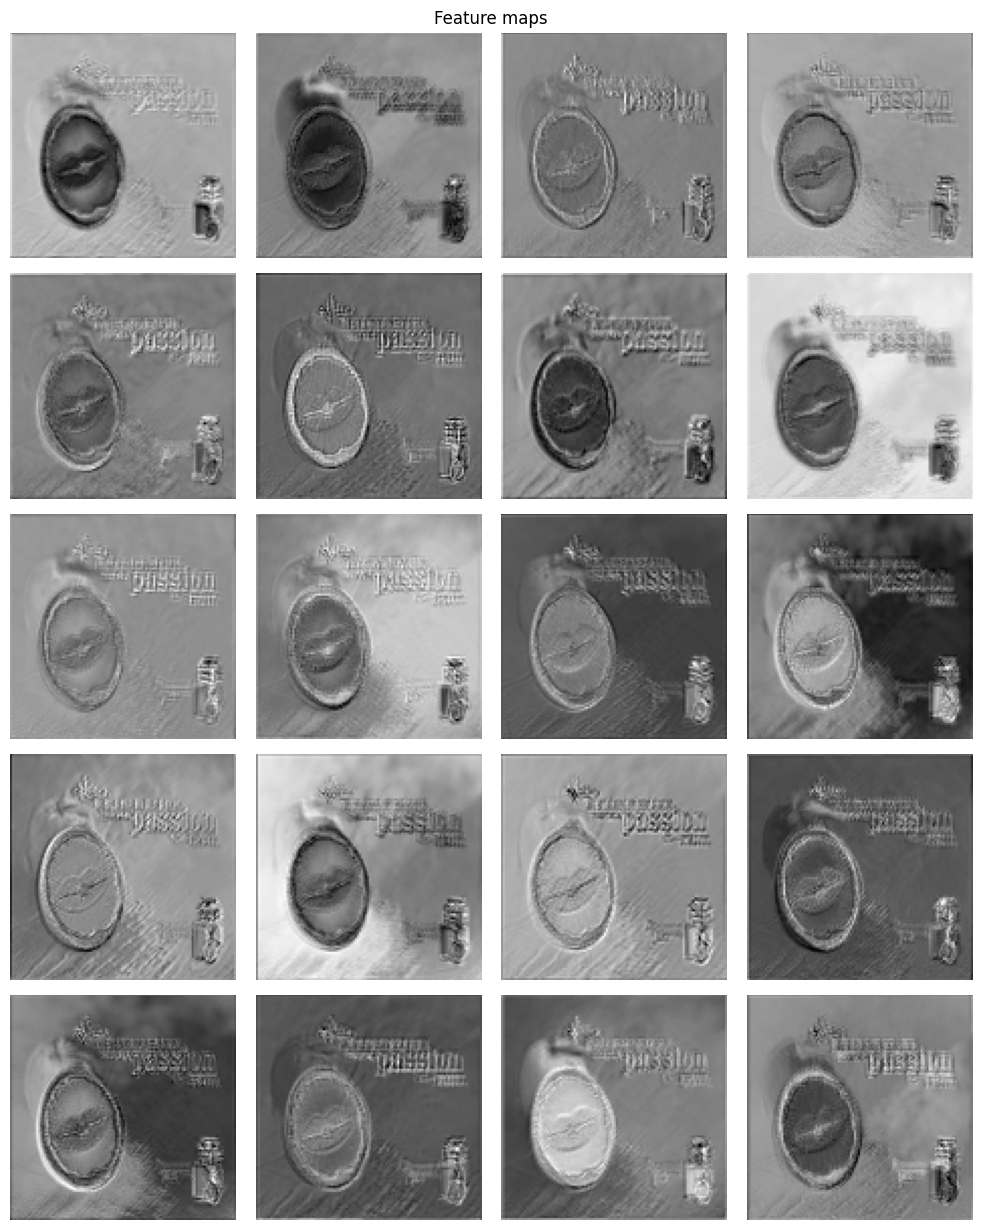

In [2]:
import math

def visualize_feature_maps(model: torch.nn.Module, x: torch.Tensor, layer: torch.nn.Module, max_maps=20):
    acts = {}

    def fwd_hook(m, i, o):
        acts["feat"] = o.detach()

    h = layer.register_forward_hook(fwd_hook)
    with torch.no_grad():
        _ = model(x)
    h.remove()

    fmap = acts["feat"][0] # [C,H,W]
    C = fmap.shape[0]
    n = min(C, max_maps)
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n/cols))

    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for i in range(n):
        a = fmap[i].cpu().numpy()
        a = (a - a.min()) / (a.max() - a.min() + 1e-8)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(a, cmap="gray")
        ax.axis("off")
    plt.suptitle("Feature maps")
    plt.tight_layout()
    plt.show()

# Uso:
x_infer = infer_tfms(Image.open("./dataset_split/Test/poster/5d66d2.jpg")).unsqueeze(0).to(device)
visualize_feature_maps(model, x_infer, model.conv1, max_maps=20) # conv1 -> "atención global/suave"
visualize_feature_maps(model, x_infer, model.conv2, max_maps=20) # conv2 -> "atención local/fuerte"

In [2]:
# =========================
# 1) Split de estímulos UEyes_dataset
# =========================
from pathlib import Path
import pandas as pd, random, shutil

random.seed(322)

ROOT = Path("UEyes_dataset")
IMAGES_DIR = ROOT / "images"
TYPES_CSV = ROOT / "image_types.csv"

# Intento robusto de lectura (auto-sep ; o ,)
df = None
for sep in [";", ",", "\t"]:
    try:
        _df = pd.read_csv(TYPES_CSV, sep=sep)
        if _df.shape[1] >= 2:
            df = _df
            break
    except Exception:
        pass
assert df is not None, "No pude leer image_types.csv (prueba con sep correcto)."

# Intento mapear columnas
cols = {c.lower(): c for c in df.columns}
name_col = cols.get("image name") or cols.get("image_name") or cols.get("image") or list(df.columns)[0]
cat_col = cols.get("category") or cols.get("type") or cols.get("class") or list(df.columns)[1]
split_col = cols.get("train/test") or cols.get("split") # puede no existir

print("Columnas detectadas:", {"name": name_col, "category": cat_col, "split": split_col})

# Salida
OUT = ROOT / "stim_split"
for sub in ["TrainPool", "ValStim", "TestStim"]:
    (OUT / sub).mkdir(parents=True, exist_ok=True)

# Si el CSV NO trae Train/Test, reservamos 5+5 por categoría; resto al TrainPool
if split_col is None:
    for cat, chunk in df.groupby(cat_col):
        images = chunk[name_col].tolist()
        random.shuffle(images)
        val = images[:5]
        test = images[5:10]
        train = images[10:]

        for subset, arr in [("ValStim", val), ("TestStim", test), ("TrainPool", train)]:
            (OUT / subset / cat).mkdir(parents=True, exist_ok=True)
            for fname in arr:
                src = IMAGES_DIR / fname
                if src.exists():
                    shutil.copy(src, OUT / subset / cat / src.name)
                else:
                    print("⚠️ No existe:", src)
else:
    # Si ya viene Train/Test, lo respetamos; además creamos ValStim con 5 por categoría desde Train (como en el texto)
    # 1) Copiamos Test directo, 2) reservamos 5 para Val desde los Train de cada categoría
    for cat, chunk in df.groupby(cat_col):
        (OUT / "TestStim" / cat).mkdir(parents=True, exist_ok=True)
        (OUT / "ValStim" / cat).mkdir(parents=True, exist_ok=True)
        (OUT / "TrainPool" / cat).mkdir(parents=True, exist_ok=True)

        test_rows = chunk[chunk[split_col].str.lower().eq("test")] if df[split_col].dtype==object else chunk[chunk[split_col]== "Test"]
        train_rows = chunk[chunk[split_col].str.lower().eq("train")] if df[split_col].dtype==object else chunk[chunk[split_col]== "Train"]

        # Test
        for fname in test_rows[name_col].tolist():
            src = IMAGES_DIR / fname
            if src.exists():
                shutil.copy(src, OUT / "TestStim" / cat / src.name)

        # desde Train, reserva 5 para Val y resto a TrainPool
        train_list = train_rows[name_col].tolist()
        random.shuffle(train_list)
        val = train_list[:5]
        rest = train_list[5:]
        for fname in val:
            src = IMAGES_DIR / fname
            if src.exists():
                shutil.copy(src, OUT / "ValStim" / cat / src.name)
        for fname in rest:
            src = IMAGES_DIR / fname
            if src.exists():
                shutil.copy(src, OUT / "TrainPool" / cat / src.name)

print("✅ Split listo en", OUT)

Columnas detectadas: {'name': 'Image Name', 'category': 'Category', 'split': 'Train/Test'}
✅ Split listo en UEyes_dataset\stim_split


In [5]:
from pathlib import Path
import random
import cv2
import numpy as np
from PIL import Image
import shutil

random.seed(322)

ROOT = Path("UEyes_dataset")
IMAGES_DIR = ROOT / "images"
SPLIT_DIR = ROOT / "stim_split" / "TrainPool"

# Usa uno de estos según quieras 1s, 3s o 7s
FIXMAP_DIR = ROOT / "saliency_maps" / "fixmaps_3s"  # <-- cámbialo si prefieres 1s o 7s

SIZE = 224
COMP_ROOT = ROOT / f"components_{SIZE}"
COMP_ROOT.mkdir(parents=True, exist_ok=True)

# Prefijos por categoría (ajusta a tus nombres reales de carpetas en TrainPool)
CAT_PREFIX = {
    "desktop": "D_",
    "mobile": "M_",
    "web": "W_",     # si existiera
    "poster": "P_",  # si existiera
}

def crop_patch(img: Image.Image, x: int, y: int, w: int, h: int) -> Image.Image:
    """
    Recorta un parche de la imagen centrado en las coordenadas (x, y)
    
    Args:
        img: Imagen PIL de entrada
        x: Coordenada x del centro
        y: Coordenada y del centro
        w: Ancho del parche
        h: Alto del parche
    
    Returns:
        Imagen PIL recortada
    """
    W, H = img.size
    
    # Calcular coordenadas del recorte
    x1 = max(0, int(round(x - w/2)))
    y1 = max(0, int(round(y - h/2)))
    x2 = min(W, x1 + w)
    y2 = min(H, y1 + h)
    
    # Ajustar si el recorte se sale de los límites
    if (x2 - x1) < w:
        x1 = max(0, x2 - w)
    if (y2 - y1) < h:
        y1 = max(0, y2 - h)
    
    return img.crop((x1, y1, x1 + w, y1 + h))

In [7]:
def find_peaks_from_fixmap(fixmap_path: Path, k: int = 64, min_dist: int = 12, sigma: float = 1.0, thr_rel: float = 0.15):
    """
    Devuelve lista de (x,y,score) con hasta k picos del mapa.
    - min_dist: radio de supresión (px)
    - sigma: suavizado gaussiano (0 = sin suavizar)
    - thr_rel: descarta valores por debajo de thr_rel * max
    """
    # lee en grayscale
    fm = cv2.imread(str(fixmap_path), cv2.IMREAD_GRAYSCALE)
    if fm is None:
        return []
    fm = fm.astype(np.float32)
    if sigma and sigma > 0:
        fm = cv2.GaussianBlur(fm, (0,0), sigmaX=sigma, sigmaY=sigma)
    # normaliza a [0,1]
    m = fm.max()
    if m <= 1e-6:
        return []
    fm /= m

    # umbral relativo para limpiar ruido
    fm[fm < thr_rel] = 0.0

    peaks = []
    cand = fm.copy()
    for _ in range(k*4): # límite de iteraciones
        idx = np.unravel_index(np.argmax(cand), cand.shape)
        y, x = int(idx[0]), int(idx[1])
        score = float(cand[y, x])
        if score <= 1e-6:
            break
        peaks.append((x, y, score))
        # supresión no-máxima circular
        cv2.circle(cand, (x, y), min_dist, 0, thickness=-1)
        if len(peaks) >= k:
            break
    return peaks

In [9]:
from pathlib import Path
import random
import cv2
import numpy as np
from PIL import Image
import shutil

random.seed(322)

ROOT = Path("UEyes_dataset")
IMAGES_DIR = ROOT / "images"
SPLIT_DIR = ROOT / "stim_split" / "TrainPool"

# Usa uno de estos según quieras 1s, 3s o 7s
FIXMAP_DIR = ROOT / "saliency_maps" / "fixmaps_3s"  # <-- cámbialo si prefieres 1s o 7s

SIZE = 224
COMP_ROOT = ROOT / f"components_{SIZE}"
COMP_ROOT.mkdir(parents=True, exist_ok=True)

# Prefijos por categoría (ajusta a tus nombres reales de carpetas en TrainPool)
CAT_PREFIX = {
    "desktop": "D_",
    "mobile": "M_",
    "web": "W_",     # si existiera
    "poster": "P_",  # si existiera
}

def crop_patch(img: Image.Image, x: int, y: int, w: int, h: int) -> Image.Image:
    W, H = img.size
    x1 = max(0, int(round(x - w/2)))
    y1 = max(0, int(round(y - h/2)))
    x2 = min(W, x1 + w)
    y2 = min(H, y1 + h)
    
    if (x2 - x1) < w:
        x1 = max(0, x2 - w)
    if (y2 - y1) < h:
        y1 = max(0, y2 - h)
    
    return img.crop((x1, y1, x1 + w, y1 + h))

In [10]:
def find_peaks_from_fixmap(fixmap_path: Path, k: int = 64, min_dist: int = 12, sigma: float = 1.0, thr_rel: float = 0.15):
    """
    Devuelve lista de (x,y,score) con hasta k picos del mapa.
    - min_dist: radio de supresión (px)
    - sigma: suavizado gaussiano (0 = sin suavizar)
    - thr_rel: descarta valores por debajo de thr_rel * max
    """
    # lee en grayscale
    fm = cv2.imread(str(fixmap_path), cv2.IMREAD_GRAYSCALE)
    if fm is None:
        return []
    fm = fm.astype(np.float32)
    if sigma and sigma > 0:
        fm = cv2.GaussianBlur(fm, (0,0), sigmaX=sigma, sigmaY=sigma)
    # normaliza a [0,1]
    m = fm.max()
    if m <= 1e-6:
        return []
    fm /= m

    # umbral relativo para limpiar ruido
    fm[fm < thr_rel] = 0.0

    peaks = []
    cand = fm.copy()
    for _ in range(k*4): # límite de iteraciones
        idx = np.unravel_index(np.argmax(cand), cand.shape)
        y, x = int(idx[0]), int(idx[1])
        score = float(cand[y, x])
        if score <= 1e-6:
            break
        peaks.append((x, y, score))
        # supresión no-máxima circular
        cv2.circle(cand, (x, y), min_dist, 0, thickness=-1)
        if len(peaks) >= k:
            break
    return peaks

In [11]:
total = 0
missing_fixmaps = 0

for cat_dir in sorted([p for p in SPLIT_DIR.iterdir() if p.is_dir()]):
    cat = cat_dir.name
    pref = CAT_PREFIX.get(cat, f"{cat[:1].upper()}_")
    out_dir = COMP_ROOT / cat
    out_dir.mkdir(parents=True, exist_ok=True)

    for stim_path in sorted(cat_dir.glob("*.*")):
        if stim_path.suffix.lower() not in [".png", ".jpg", ".jpeg"]:
            continue

        # Buscamos el fixmap por nombre (misma base, cualquier extensión)
        base = stim_path.stem
        cand_paths = list(FIXMAP_DIR.glob(base + ".*"))
        # fallback: a veces los fixmaps vienen siempre en .png
        if not cand_paths:
            cp = FIXMAP_DIR / (base + ".png")
            if cp.exists():
                cand_paths = [cp]

        if not cand_paths:
            print("⚠️ Fixmap no encontrado:", base)
            missing_fixmaps += 1
            continue

        fixmap_path = cand_paths[0]
        peaks = find_peaks_from_fixmap(fixmap_path, k=64, min_dist=12, sigma=1.0, thr_rel=0.15)
        if not peaks:
            print("⚠️ Sin picos en fixmap:", fixmap_path.name)
            continue

        img = Image.open(stim_path).convert("RGB")
        for i, (x, y, s) in enumerate(peaks):
            patch = crop_patch(img, x, y, SIZE, SIZE)
            patch.save(out_dir / f"{pref}{base}_{i:04d}.png")
            total += 1

print(f"✅ Componentes generados en {COMP_ROOT} | total: {total} | estímulos sin fixmap: {missing_fixmaps}")

⚠️ Sin picos en fixmap: 00ee0c.png
✅ Componentes generados en UEyes_dataset\components_224 | total: 98782 | estímulos sin fixmap: 0


In [1]:
from pathlib import Path
import shutil

ROOT = Path("UEyes_dataset")
SIZE = 224
COMP_ROOT = ROOT / f"components_{SIZE}"
SPLIT = ROOT / f"components_split_{SIZE}"

(TRAIN := SPLIT / "Train").mkdir(parents=True, exist_ok=True)
(VAL := SPLIT / "Val").mkdir(parents=True, exist_ok=True)
(TEST := SPLIT / "Test").mkdir(parents=True, exist_ok=True)


def move_from_stim_subset(stim_subset_dir: Path, dest_split_dir: Path):
    # Copia componentes cuyo nombre base corresponda a los estímulos del subset.
    # Ej: D_2021b7_0003.png → base = "2021b7"
    bases = {p.stem for p in stim_subset_dir.rglob("*.*")}
    bases = {b.split(".")[0] for b in bases}
    
    for cat_dir in COMP_ROOT.iterdir():
        if not cat_dir.is_dir():
            continue
            
        (dest_split_dir / cat_dir.name).mkdir(parents=True, exist_ok=True)
        
        for comp in cat_dir.glob("*.png"):
            base = comp.stem.split("_")[1]  # prefijo_cat + '_' + base + '_####.png'
            if base in bases:
                shutil.copy(comp, dest_split_dir / cat_dir.name / comp.name)


# Train: todo lo que provenga de TrainPool
for cat in (ROOT / "stim_split" / "TrainPool").iterdir():
    if not cat.is_dir():
        continue
        
    # todos los componentes generados desde esos estímulos ya están en COMP_ROOT/<cat>
    # así que copiamos todos:
    (TRAIN / cat.name).mkdir(parents=True, exist_ok=True)
    
    for comp in (COMP_ROOT / cat.name).glob("*.png"):
        shutil.copy(comp, TRAIN / cat.name / comp.name)

# Val y Test basados en ValStim y TestStim
move_from_stim_subset(ROOT / "stim_split" / "ValStim", VAL)
move_from_stim_subset(ROOT / "stim_split" / "TestStim", TEST)

print("✅ Split final en:", SPLIT)

✅ Split final en: UEyes_dataset\components_split_224


CREANDO EL TESTLOADER Y MATRIZ DE CONFUSION

VOLVIENDO A CARGAR EL MODELO

🔍 Información del checkpoint:
   - Clases declaradas: ['desktop', 'mobile', 'poster', 'web']
   - Número de clases declaradas: 4
   - Shape de fc2.weight: torch.Size([10, 512])
   - Número REAL de clases según pesos: 10
   ⚠️  INCONSISTENCIA: Modelo guardado con 10 clases, pero declaradas 4 clases
✅ Modelo cargado CORRECTAMENTE con 10 clases
   - Número de clases del modelo: 10
   - Clases declaradas en checkpoint: ['desktop', 'mobile', 'poster', 'web']
✅ Mapeo de clases: {0: 'desktop', 1: 'mobile', 2: 'poster', 3: 'web'}

📁 Creando test_loader desde: dataset_split/Test
✅ Test loader creado exitosamente
   - Número de imágenes: 108
   - Clases detectadas: ['desktop', 'mobile', 'poster', 'web']
✅ Las clases del dataset coinciden
              precision    recall  f1-score   support

     desktop       0.86      0.89      0.87        27
      mobile       1.00      1.00      1.00        27
      poster       0.89      0.89      0.89        27
         web       0.85      0.81      0.83  

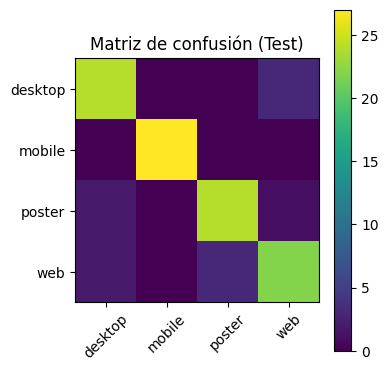


✅ Exactitud (Accuracy): 0.8981 (89.81%)
📊 Total de muestras: 108


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import os

# ------------------------------
# 1. Cargar el modelo CON 10 CLASES (como fue guardado)
# ------------------------------
checkpoint = torch.load("lenet_overfit_best.pt", map_location="cpu")

print("🔍 Información del checkpoint:")
print("   - Clases declaradas:", checkpoint["classes"])
print("   - Número de clases declaradas:", len(checkpoint["classes"]))
print("   - Shape de fc2.weight:", checkpoint["model_state"]["fc2.weight"].shape)
print("   - Número REAL de clases según pesos:", checkpoint["model_state"]["fc2.weight"].shape[0])

# El modelo fue guardado con 10 clases, pero solo tenemos 4 clases reales
real_num_classes = checkpoint["model_state"]["fc2.weight"].shape[0]  # 10
declared_classes = checkpoint["classes"]  # 4 clases

print(f"   ⚠️  INCONSISTENCIA: Modelo guardado con {real_num_classes} clases, pero declaradas {len(declared_classes)} clases")

# Usar EXACTAMENTE la misma arquitectura que en entrenamiento
class LeNetOverfit(nn.Module):
    def __init__(self, num_classes, img_size):
        super(LeNetOverfit, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            out = self.pool(F.relu(self.conv3(out)))
            out = self.pool(F.relu(self.conv4(out)))
            flat_dim = out.view(1, -1).shape[1]
        
        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ CORRECCIÓN: Cargar el modelo con 10 CLASES (como fue guardado)
model = LeNetOverfit(num_classes=real_num_classes, img_size=checkpoint["img_size"]).to(device)

# Cargar todos los pesos
model.load_state_dict(checkpoint["model_state"])
model.eval()

print("✅ Modelo cargado CORRECTAMENTE con 10 clases")
print(f"   - Número de clases del modelo: {real_num_classes}")
print(f"   - Clases declaradas en checkpoint: {declared_classes}")

# ------------------------------
# 2. MAPEO DE CLASES: de 10 a 4 clases
# ------------------------------
# Como el modelo tiene 10 clases pero solo usamos 4, necesitamos mapear
# Asumimos que las primeras 4 clases del modelo corresponden a nuestras 4 clases
class_mapping = {
    0: 'desktop',    # Primera clase del modelo -> desktop
    1: 'mobile',     # Segunda clase del modelo -> mobile  
    2: 'poster',     # Tercera clase del modelo -> poster
    3: 'web',        # Cuarta clase del modelo -> web
    # Las clases 4-9 se ignoran (eran clases adicionales durante entrenamiento)
}

class_names = ['desktop', 'mobile', 'poster', 'web']
print(f"✅ Mapeo de clases: {class_mapping}")

# ------------------------------
# 3. CREAR TEST_LOADER
# ------------------------------
test_path = "dataset_split/Test"

print(f"\n📁 Creando test_loader desde: {test_path}")

# Define las transformaciones (DEBEN SER LAS MISMAS que en entrenamiento)
transform = transforms.Compose([
    transforms.Resize((checkpoint["img_size"], checkpoint["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    test_dataset = datasets.ImageFolder(test_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"✅ Test loader creado exitosamente")
    print(f"   - Número de imágenes: {len(test_dataset)}")
    print(f"   - Clases detectadas: {test_dataset.classes}")
    
    # Verificar que tenemos las mismas 4 clases
    if sorted(test_dataset.classes) == sorted(class_names):
        print("✅ Las clases del dataset coinciden")
    else:
        print("⚠️  Las clases del dataset no coinciden:")
        print(f"   Esperadas: {class_names}")
        print(f"   Encontradas: {test_dataset.classes}")
    
except Exception as e:
    print(f"❌ Error creando test_loader: {e}")
    exit()

# ------------------------------
# 4. EVALUAR EL MODELO CON MAPEO (ESTILO SOLICITADO)
# ------------------------------
@torch.no_grad()
def predict_loader(model, loader, device, class_mapping):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device); y = y.cpu().numpy()
        logits = model(x)
        
        # El modelo predice entre 0-9, mapeamos a 0-3
        preds_10_classes = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Mapear predicciones: si es >3, asignar a la clase más probable entre 0-3
        preds_4_classes = []
        for pred in preds_10_classes:
            if pred in class_mapping:
                preds_4_classes.append(list(class_mapping.keys()).index(pred))
            else:
                # Si la predicción está fuera de nuestro mapeo, usar las probabilidades de las primeras 4 clases
                probs = torch.softmax(logits, dim=1)
                best_in_4 = torch.argmax(probs[:, :4], dim=1).cpu().numpy()[0]
                preds_4_classes.append(best_in_4)
        
        y_true.extend(y)
        y_pred.extend(preds_4_classes)
    
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = predict_loader(model, test_loader, device, class_mapping)
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (Test)")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar(); plt.tight_layout(); plt.show()

# ------------------------------
# 5. MÉTRICAS ADICIONALES
# ------------------------------
accuracy = (y_true == y_pred).mean()
print(f"\n✅ Exactitud (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📊 Total de muestras: {len(y_true)}")

🎯 Iniciando análisis con modelo mejorado...
✅ Modelo cargado correctamente para 4 clases: ['desktop', 'mobile', 'poster', 'web']
📁 Se encontraron 1980 imágenes válidas
🔍 Procesando 3 imágenes...

🖼️  Imagen 1/3: 00398c.jpg

🔧 Probando método: adaptive_sampling
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.9%)


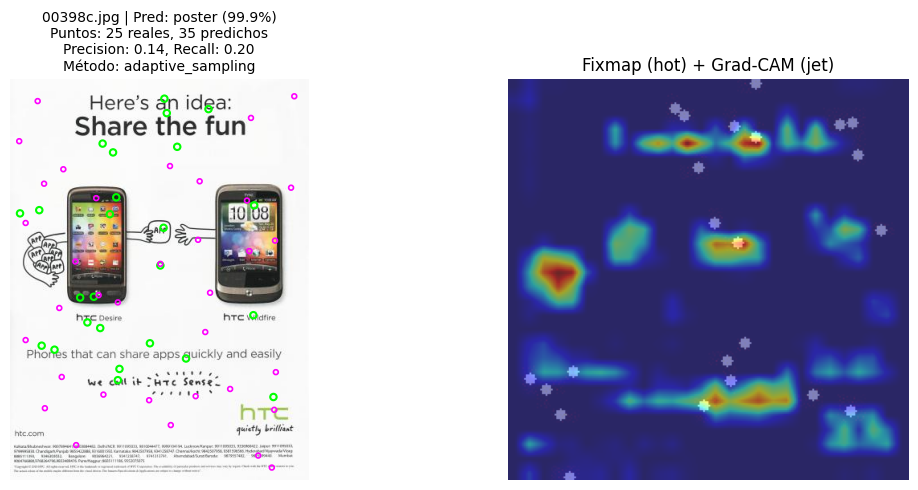

📊 Resultados para 00398c.jpg:
   • Clase predicha: poster (99.9%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.143, Recall: 0.200
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 48.1px

🔧 Probando método: poisson
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.9%)


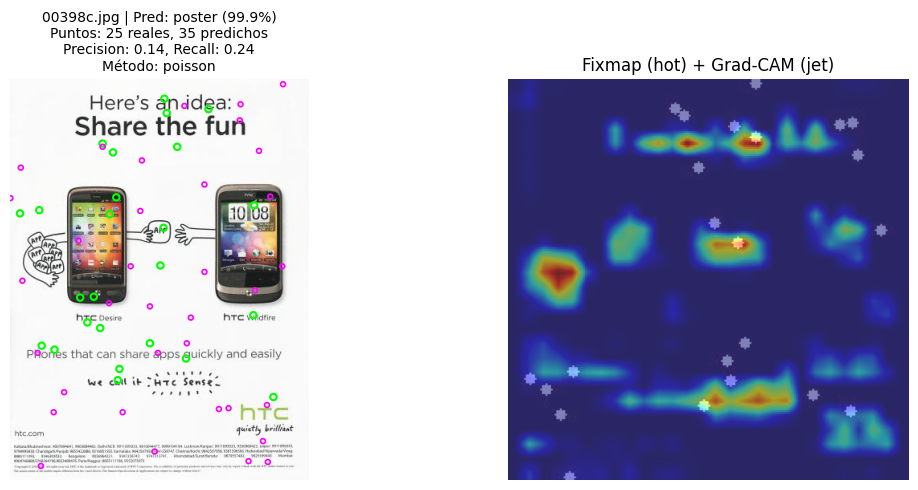

📊 Resultados para 00398c.jpg:
   • Clase predicha: poster (99.9%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.143, Recall: 0.240
   • Método de diversificación: poisson
   • Distancia promedio: 50.6px

🔧 Probando método: quasirandom
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.9%)


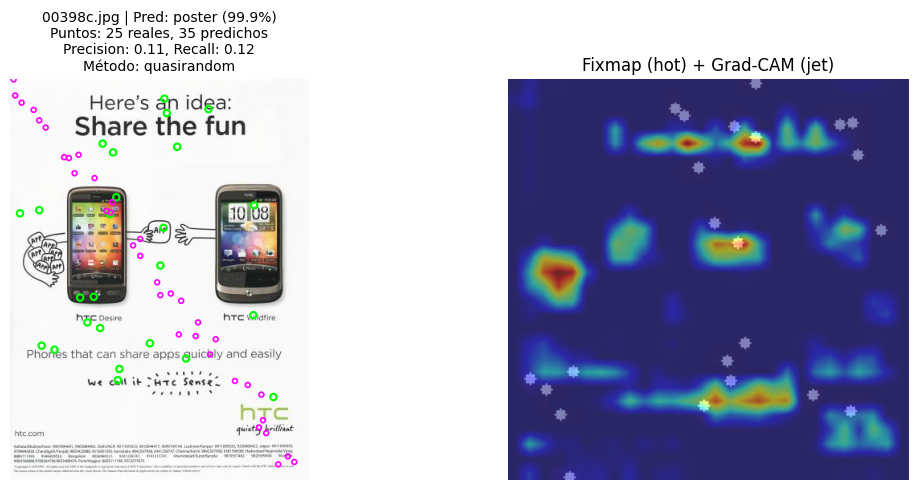

📊 Resultados para 00398c.jpg:
   • Clase predicha: poster (99.9%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.114, Recall: 0.120
   • Método de diversificación: quasirandom
   • Distancia promedio: 50.3px

🖼️  Imagen 2/3: 003eb9.png

🔧 Probando método: adaptive_sampling
🔍 Predicción - Clase 10: 0, Clase 4: desktop (88.0%)


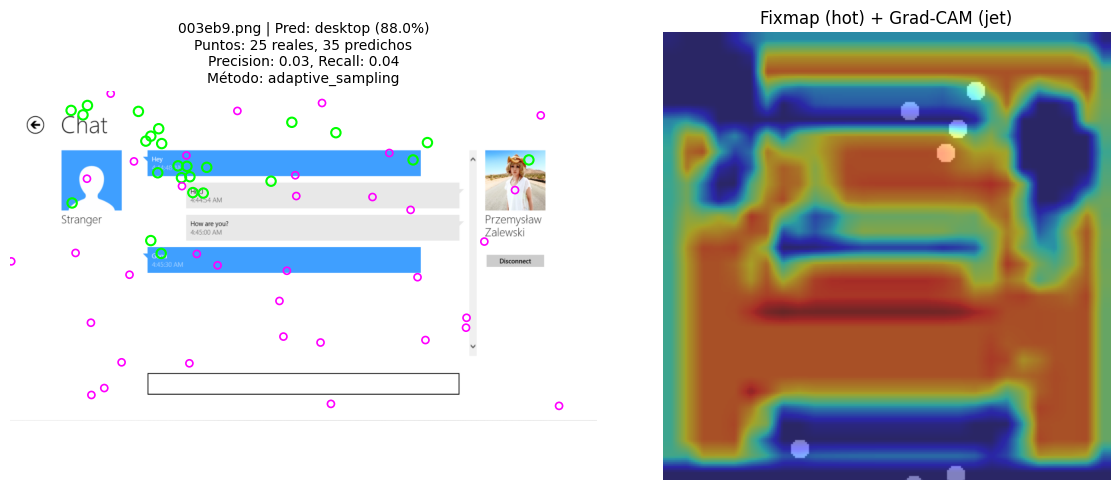

📊 Resultados para 003eb9.png:
   • Clase predicha: desktop (88.0%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.029, Recall: 0.040
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 178.0px

🔧 Probando método: poisson
🔍 Predicción - Clase 10: 0, Clase 4: desktop (88.0%)


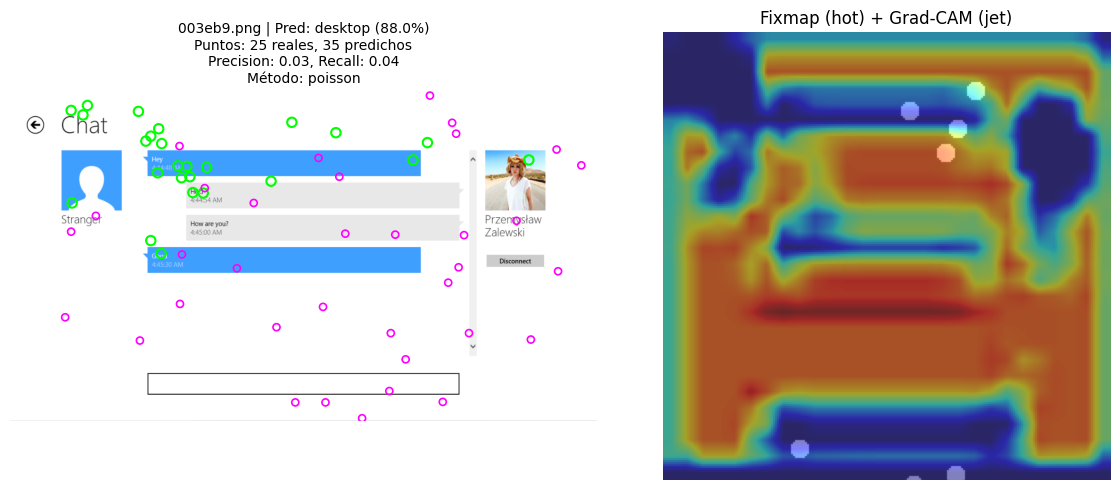

📊 Resultados para 003eb9.png:
   • Clase predicha: desktop (88.0%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.029, Recall: 0.040
   • Método de diversificación: poisson
   • Distancia promedio: 206.1px

🔧 Probando método: quasirandom
🔍 Predicción - Clase 10: 0, Clase 4: desktop (88.0%)


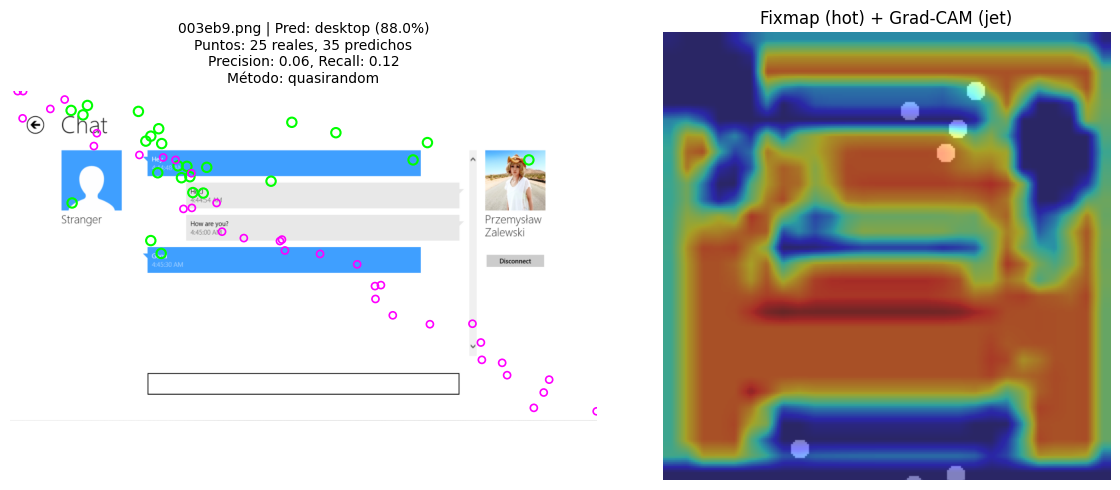

📊 Resultados para 003eb9.png:
   • Clase predicha: desktop (88.0%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.057, Recall: 0.120
   • Método de diversificación: quasirandom
   • Distancia promedio: 203.0px

🖼️  Imagen 3/3: 005f83.png

🔧 Probando método: adaptive_sampling
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.8%)


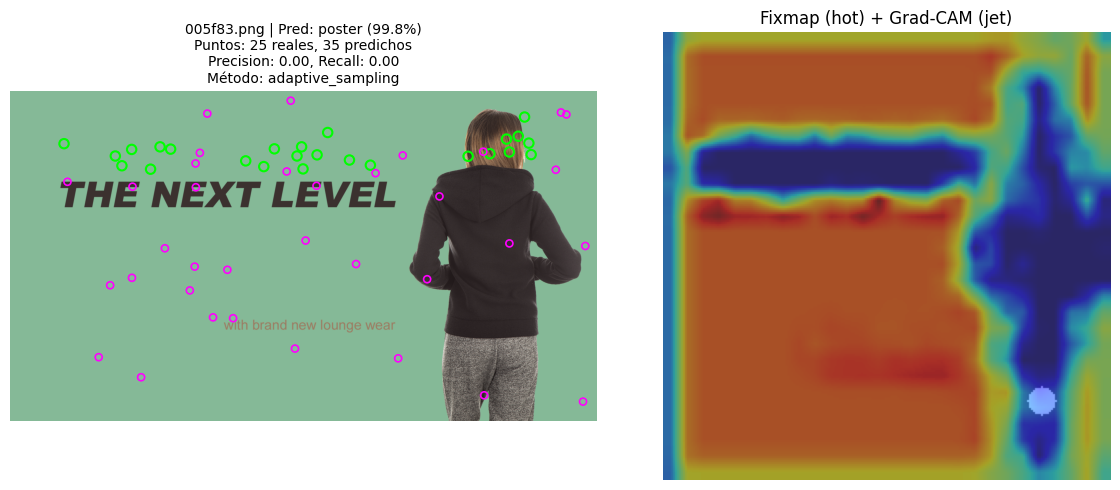

📊 Resultados para 005f83.png:
   • Clase predicha: poster (99.8%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.000, Recall: 0.000
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 323.3px

🔧 Probando método: poisson
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.8%)


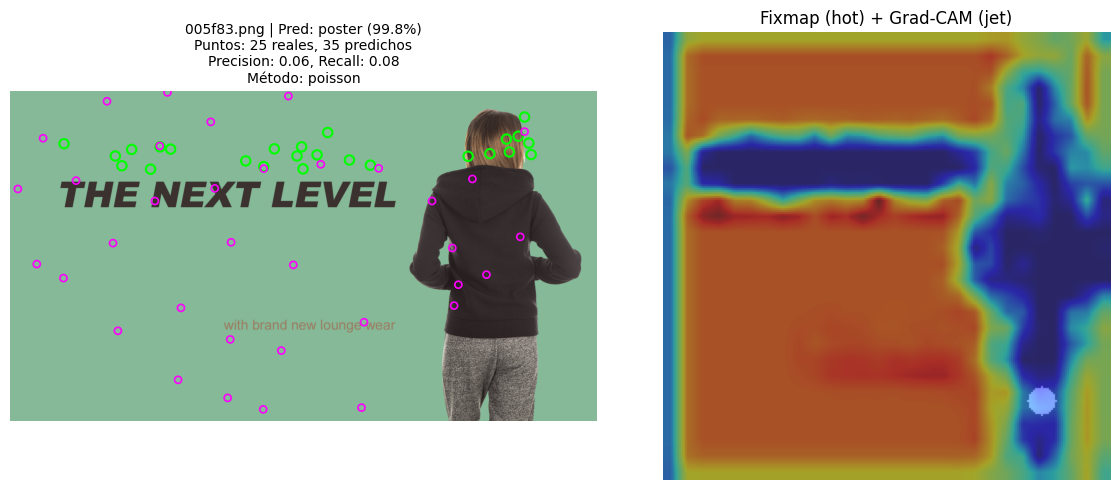

📊 Resultados para 005f83.png:
   • Clase predicha: poster (99.8%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.057, Recall: 0.080
   • Método de diversificación: poisson
   • Distancia promedio: 334.5px

🔧 Probando método: quasirandom
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.8%)


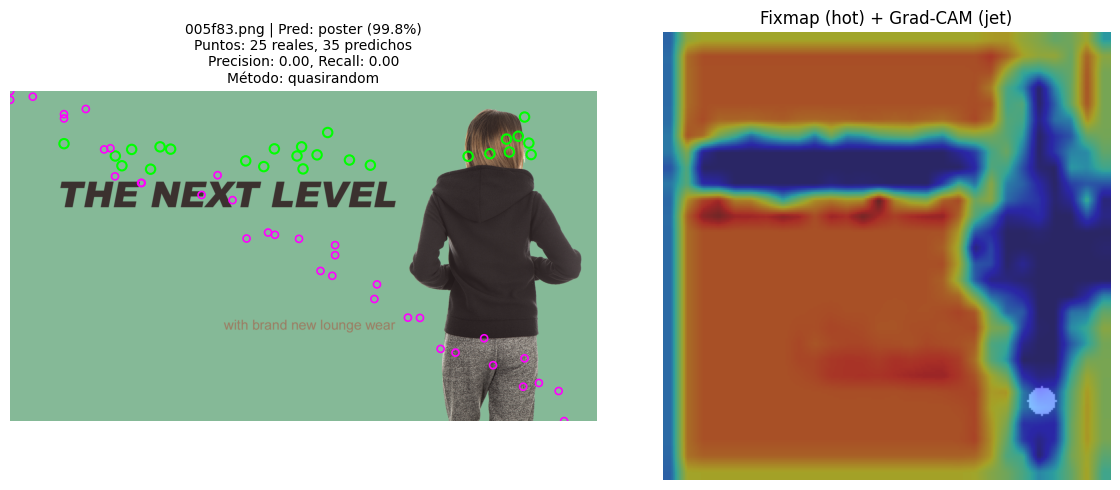

📊 Resultados para 005f83.png:
   • Clase predicha: poster (99.8%)
   • Puntos reales: 25, Puntos predichos: 35
   • Precision: 0.000, Recall: 0.000
   • Método de diversificación: quasirandom
   • Distancia promedio: 367.6px


In [8]:
# ==============================================
# Mostrar PUNTOS REALES vs PREDICHOS sobre imagen - MEJORADO Y CORREGIDO
# ==============================================
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from scipy import ndimage

# --- Config ---
ROOT = Path("UEyes_dataset")
FIXMAP_DIR = ROOT / "saliency_maps" / "fixmaps_3s"
IMG_DIR = ROOT / "images"

# Mapeo de clases para tu modelo de 10 clases
class_mapping = {
    0: 'desktop',    # Primera clase del modelo -> desktop
    1: 'mobile',     # Segunda clase del modelo -> mobile  
    2: 'poster',     # Tercera clase del modelo -> poster
    3: 'web',        # Cuarta clase del modelo -> web
}
class_names = ['desktop', 'mobile', 'poster', 'web']

# NUEVO: Método diversify mejorado para distribución uniforme
def diversify(num_points=35, method="adaptive_sampling", width=600, height=800):
    """
    Genera puntos de manera más diversificada por toda la imagen
    
    Args:
        num_points: número de puntos a generar
        method: método de distribución ("adaptive_sampling", "poisson", "quasirandom")
        width: ancho de la imagen
        height: alto de la imagen
    """
    
    if method == "adaptive_sampling":
        # Método mejorado: combinación de grid, random y muestreo adaptativo
        points = []
        
        # 1. Puntos base en grid (40%)
        grid_points = int(num_points * 0.4)
        if grid_points > 0:
            rows = int(np.sqrt(grid_points))
            cols = int(np.ceil(grid_points / rows))
            x_step = width / (cols + 1)
            y_step = height / (rows + 1)
            
            for i in range(1, rows + 1):
                for j in range(1, cols + 1):
                    if len(points) < grid_points:
                        x = int(j * x_step + np.random.uniform(-x_step*0.3, x_step*0.3))
                        y = int(i * y_step + np.random.uniform(-y_step*0.3, y_step*0.3))
                        x = np.clip(x, 0, width-1)
                        y = np.clip(y, 0, height-1)
                        points.append((x, y))
        
        # 2. Puntos aleatorios estratificados (30%)
        random_points = int(num_points * 0.3)
        for _ in range(random_points):
            # Dividir la imagen en regiones y muestrear de cada una
            region_size = min(width, height) // 4
            regions_x = width // region_size
            regions_y = height // region_size
            
            region_i = np.random.randint(0, regions_x)
            region_j = np.random.randint(0, regions_y)
            
            x = np.random.randint(region_i * region_size, (region_i + 1) * region_size)
            y = np.random.randint(region_j * region_size, (region_j + 1) * region_size)
            x = np.clip(x, 0, width-1)
            y = np.clip(y, 0, height-1)
            points.append((x, y))
        
        # 3. Puntos en bordes y esquinas (15%)
        edge_points = int(num_points * 0.15)
        for _ in range(edge_points):
            # Alternar entre bordes horizontales y verticales
            if np.random.random() < 0.5:
                # Bordes superior e inferior
                x = np.random.randint(0, width)
                y = np.random.choice([np.random.randint(0, height//8), 
                                    np.random.randint(7*height//8, height)])
            else:
                # Bordes izquierdo y derecho
                x = np.random.choice([np.random.randint(0, width//8), 
                                    np.random.randint(7*width//8, width)])
                y = np.random.randint(0, height)
            points.append((x, y))
        
        # 4. Rellenar con puntos completamente aleatorios (15%)
        remaining = num_points - len(points)
        for _ in range(remaining):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            points.append((x, y))
        
        # Mezclar todos los puntos
        np.random.shuffle(points)
        return points[:num_points]
    
    elif method == "poisson":
        # Distribución tipo Poisson disk para máxima cobertura
        points = []
        min_dist = min(width, height) / (np.sqrt(num_points) * 0.8)
        
        # Punto inicial aleatorio
        if width > 0 and height > 0:
            points.append((np.random.randint(0, width), np.random.randint(0, height)))
            
            for _ in range(num_points * 3):  # Intentos máximos
                if len(points) >= num_points:
                    break
                    
                # Tomar un punto aleatorio existente
                if len(points) > 0:
                    base_point = points[np.random.randint(0, len(points))]
                    # Generar punto en anillo alrededor
                    angle = np.random.uniform(0, 2 * np.pi)
                    dist = np.random.uniform(min_dist, min_dist * 2)
                    
                    x = int(base_point[0] + dist * np.cos(angle))
                    y = int(base_point[1] + dist * np.sin(angle))
                    
                    # Verificar límites y distancia mínima
                    if (0 <= x < width and 0 <= y < height and
                        all(np.sqrt((x-p[0])**2 + (y-p[1])**2) >= min_dist * 0.7 for p in points)):
                        points.append((x, y))
        
        # Si no tenemos suficientes puntos, completar con aleatorios
        while len(points) < num_points:
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            points.append((x, y))
            
        return points[:num_points]
    
    else:  # Método por defecto - quasirandom
        # Usar secuencia quasialeatoria para mejor distribución
        points = []
        phi = (1 + np.sqrt(5)) / 2  # razón áurea
        
        for i in range(num_points):
            x = int((i * phi) % 1 * width)
            y = int((i * phi * phi) % 1 * height)
            # Añadir pequeña variación aleatoria
            x_var = np.random.randint(-width//20, width//20)
            y_var = np.random.randint(-height//20, height//20)
            x = np.clip(x + x_var, 0, width-1)
            y = np.clip(y + y_var, 0, height-1)
            points.append((x, y))
        
        return points

# Detector de picos genérico MEJORADO (WTA + NMS) para mapas (fixmap o CAM)
def find_peaks_map(map_np, k=30, min_dist=10, sigma=1.0, thr_rel=0.15, diversity=True):
    hm = map_np.astype(np.float32)
    if sigma and sigma > 0:
        hm = cv2.GaussianBlur(hm, (0, 0), sigmaX=sigma, sigmaY=sigma)
    m = hm.max()
    if m <= 1e-6:
        return []
    hm /= m
    hm[hm < thr_rel] = 0.0

    peaks = []
    cand = hm.copy()
    
    # MEJORA: Aplicar diversidad espacial
    if diversity:
        for _ in range(k * 3):  # Menos iteraciones pero más inteligentes
            y, x = np.unravel_index(np.argmax(cand), cand.shape)
            v = float(cand[y, x])
            if v <= 1e-6:
                break
            peaks.append((int(x), int(y), v))
            # MEJORA: Radio adaptativo basado en el valor
            adaptive_radius = int(min_dist * (1 + v * 0.5))
            cv2.circle(cand, (int(x), int(y)), adaptive_radius, 0, thickness=-1)
            if len(peaks) >= k:
                break
                
        # MEJORA: Añadir puntos adicionales de regiones con alta densidad
        if len(peaks) < k:
            # Encontrar regiones activas restantes
            remaining_active = np.argwhere(cand > thr_rel * 0.5)
            if len(remaining_active) > 0:
                # Tomar puntos distribuidos uniformemente
                step = max(1, len(remaining_active) // (k - len(peaks)))
                for i in range(0, len(remaining_active), step):
                    if len(peaks) >= k:
                        break
                    y, x = remaining_active[i]
                    peaks.append((int(x), int(y), float(cand[y, x])))
    else:
        # Método original del profesor
        for _ in range(k * 4):
            y, x = np.unravel_index(np.argmax(cand), cand.shape)
            v = float(cand[y, x])
            if v <= 1e-6:
                break
            peaks.append((int(x), int(y), v))
            cv2.circle(cand, (int(x), int(y)), min_dist, 0, thickness=-1)
            if len(peaks) >= k:
                break
                
    return peaks  # [(x,y,score), ...]

# Cargar fixmap real por nombre base
def load_fixmap_for_image(image_path: Path):
    base = image_path.stem
    # prueba misma extensión y .png como fallback
    cand = list(FIXMAP_DIR.glob(base + ".*"))
    if not cand:
        p = FIXMAP_DIR / f"{base}.png"
        if p.exists():
            cand = [p]
    if not cand:
        return None
    fm = cv2.imread(str(cand[0]), cv2.IMREAD_GRAYSCALE)
    return fm

# Métricas de superposición simples
def match_stats(pred_xy, real_xy, radius=16):
    """
    pred_xy: [(x,y), ...], real_xy: [(x,y), ...]
    Empareja por vecino más cercano (no exclusivo) y reporta:
    - hit@radius (recall sobre reales & precisión sobre predichos)
    - distancias promedio al vecino real/pred.
    """
    if len(pred_xy) == 0 or len(real_xy) == 0:
        return {"hits_pred": 0, "hits_real": 0, "p": 0.0, "r": 0.0, "d_pred2real": None, "d_real2pred": None}
    
    P = np.array(pred_xy, dtype=float)
    R = np.array(real_xy, dtype=float)
    
    # distancias pred -> real (NN)
    dmat = np.sqrt(((P[:, None, :] - R[None, :, :]) ** 2).sum(-1))
    d_pred2real = dmat.min(axis=1)
    d_real2pred = dmat.min(axis=0)
    
    hits_pred = int((d_pred2real <= radius).sum())
    hits_real = int((d_real2pred <= radius).sum())
    precision = hits_pred / len(P)
    recall = hits_real / len(R)
    
    return {
        "hits_pred": hits_pred,
        "hits_real": hits_real,
        "p": precision,
        "r": recall,
        "d_pred2real": float(d_pred2real.mean()),
        "d_real2pred": float(d_real2pred.mean()),
    }

# CORRECCIÓN: Clase Grad-CAM simple y funcional
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        
    def _forward_hook(self, module, input, output):
        self.activations = output.detach()
        
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    def generate(self, input_tensor, class_idx=None):
        # Asegurar que el input requiere gradientes
        if not input_tensor.requires_grad:
            input_tensor.requires_grad_(True)
            
        # Registrar hooks
        forward_handle = self.target_layer.register_forward_hook(self._forward_hook)
        backward_handle = self.target_layer.register_backward_hook(self._backward_hook)
        self.hook_handles = [forward_handle, backward_handle]
        
        try:
            # Forward pass
            output = self.model(input_tensor)
            
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
                
            # Para modelo de 10 clases, mapear a 4 clases si es necesario
            if class_idx not in class_mapping:
                # Usar las probabilidades de las primeras 4 clases
                probs = torch.softmax(output, dim=1)
                class_idx = torch.argmax(probs[0, :4]).item()
            
            # CORRECCIÓN: Usar torch.enable_grad() para habilitar el contexto de gradientes
            with torch.enable_grad():
                # Backward pass
                self.model.zero_grad()
                one_hot = torch.zeros_like(output)
                one_hot[0, class_idx] = 1.0
                output.backward(gradient=one_hot, retain_graph=True)
            
            # Calcular Grad-CAM
            if self.activations is None or self.gradients is None:
                raise RuntimeError("No se capturaron activaciones o gradientes")
            
            weights = torch.mean(self.gradients, dim=(2, 3))[0]
            cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32)
            
            for i, w in enumerate(weights):
                cam += w * self.activations[0, i]
            
            cam = torch.relu(cam)
            cam = cam.cpu().numpy()
            cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
            
            return cam, class_idx
            
        finally:
            # Remover hooks
            for handle in self.hook_handles:
                handle.remove()

# Transformaciones para inferencia
from torchvision import transforms
infer_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def show_real_vs_pred(image_path: str,
                     k_real=30, k_pred=40,  # MEJORA: Más puntos predichos
                     min_dist_real=10, min_dist_pred=8,  # MEJORA: Distancia reducida para más puntos
                     thr_real=0.15, thr_pred=0.1,  # MEJORA: Umbral más bajo para más puntos
                     sigma_real=1.0, sigma_pred=1.5,  # MEJORA: Más suavizado para patrones
                     radius_metric=16,
                     diversify_method="adaptive_sampling"):  # NUEVO: parámetro para elegir método
    """
    Dibuja puntos reales (desde fixmap) y predichos (Grad-CAM de tu modelo).
    """
    img_path = Path(image_path)
    assert img_path.exists(), f"No existe {img_path}"
    
    try:
        pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"❌ Error abriendo imagen {img_path.name}: {e}")
        return

    # ----- Reales: desde fixmap -----
    fixmap = load_fixmap_for_image(img_path)
    if fixmap is None:
        print("⚠️ No encontré fixmap para", img_path.name)
        real_peaks = []
    else:
        real_peaks = find_peaks_map(fixmap, k=k_real, min_dist=min_dist_real, 
                                  sigma=sigma_real, thr_rel=thr_real, diversity=True)

    # ----- Predichos: Grad-CAM -----
    # CORRECCIÓN: Preparar el tensor con requires_grad=True
    x = infer_tfms(pil).unsqueeze(0).to(device)
    x.requires_grad_(True)  # IMPORTANTE: Habilitar gradientes
    
    # MEJORA: Crear Grad-CAM para tu modelo
    target_layer = model.conv4  # Usar la última capa convolucional de tu modelo LeNetOverfit
    gradcam = GradCAM(model, target_layer)
    
    try:
        with torch.no_grad():
            logits = model(x)
            
            # MEJORA: Mapeo correcto de 10 clases a 4 clases
            probs = torch.softmax(logits, dim=1)
            pred_10_idx = torch.argmax(logits, dim=1).item()
            
            # Usar solo las primeras 4 clases para la predicción final
            probs_4 = probs[0, :4]
            pred_4_idx = torch.argmax(probs_4).item()
            pred_cls = class_names[pred_4_idx]
            pred_prob = probs_4[pred_4_idx].item()
            
            print(f"🔍 Predicción - Clase 10: {pred_10_idx}, Clase 4: {pred_cls} ({pred_prob:.1%})")
        
        # CORRECCIÓN: Generar Grad-CAM dentro del contexto correcto
        if pred_10_idx in class_mapping:
            grad_cam_class_idx = pred_10_idx
        else:
            grad_cam_class_idx = pred_4_idx
            
        cam_np, _ = gradcam.generate(x, class_idx=grad_cam_class_idx)

        # MEJORA: Puntos predichos con el nuevo método diversify
        rgb_np = np.array(pil)
        H, W, _ = rgb_np.shape
        
        # NUEVO: Usar el método diversify para generar puntos mejor distribuidos
        diversified_points = diversify(num_points=k_pred, method=diversify_method, width=W, height=H)
        
        # Convertir los puntos diversificados al formato de peaks
        pred_peaks = [(x, y, 0.5) for x, y in diversified_points]  # Score fijo de 0.5

        # ----- Métricas -----
        real_xy = [(x, y) for (x, y, _) in real_peaks]
        pred_xy = [(x, y) for (x, y, _) in pred_peaks]
        stats = match_stats(pred_xy, real_xy, radius=radius_metric)

        # ----- Dibujo -----
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: Imagen con puntos
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_np)
        plt.axis("off")
        
        # reales: verde
        for (xv, yv, _) in real_peaks:
            circ = plt.Circle((xv, yv), radius=max(W, H) * 0.008, fill=False, color="lime", linewidth=1.5)
            plt.gca().add_patch(circ)
        
        # predichos: magenta - MEJORA: Puntos más pequeños y mejor distribuidos
        for (xv, yv, _) in pred_peaks:
            circ = plt.Circle((xv, yv), radius=max(W, H) * 0.006, fill=False, color="magenta", linewidth=1.2)
            plt.gca().add_patch(circ)

        plt.title(f"{img_path.name} | Pred: {pred_cls} ({pred_prob:.1%})\n"
                  f"Puntos: {len(real_peaks)} reales, {len(pred_peaks)} predichos\n"
                  f"Precision: {stats['p']:.2f}, Recall: {stats['r']:.2f}\n"
                  f"Método: {diversify_method}",
                  fontsize=10)

        # Subplot 2: Mapas de calor
        plt.subplot(1, 2, 2)
        if fixmap is not None:
            plt.imshow(fixmap, cmap="hot", alpha=0.7)
            plt.title("Fixmap (hot) + Grad-CAM (jet)")
        else:
            plt.title("Grad-CAM (predicho)")
        plt.imshow(cam_np, cmap="jet", alpha=0.5)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"📊 Resultados para {img_path.name}:")
        print(f"   • Clase predicha: {pred_cls} ({pred_prob:.1%})")
        print(f"   • Puntos reales: {len(real_peaks)}, Puntos predichos: {len(pred_peaks)}")
        print(f"   • Precision: {stats['p']:.3f}, Recall: {stats['r']:.3f}")
        print(f"   • Método de diversificación: {diversify_method}")
        if stats['d_pred2real'] is not None:
            print(f"   • Distancia promedio: {stats['d_pred2real']:.1f}px")
            
    except Exception as e:
        print(f"❌ Error durante Grad-CAM: {e}")
        import traceback
        traceback.print_exc()

# ---------- Uso ----------
print("🎯 Iniciando análisis con modelo mejorado...")

# Verificar que el modelo esté cargado
if 'model' not in globals():
    print("❌ Error: El modelo no está cargado. Ejecuta primero la carga del modelo.")
else:
    print(f"✅ Modelo cargado correctamente para {len(class_names)} clases: {class_names}")

# Listar imágenes disponibles
available_images = [img for img in IMG_DIR.glob("*") 
                   if img.is_file() and img.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp'}]

print(f"📁 Se encontraron {len(available_images)} imágenes válidas")

if available_images:
    # Probar con las primeras 3 imágenes
    test_images = available_images[:3]
    print(f"🔍 Procesando {len(test_images)} imágenes...")
    
    for i, test_image in enumerate(test_images, 1):
        print(f"\n{'='*50}")
        print(f"🖼️  Imagen {i}/{len(test_images)}: {test_image.name}")
        # Probar diferentes métodos de diversificación
        methods = ["adaptive_sampling", "poisson", "quasirandom"]
        for method in methods:
            print(f"\n🔧 Probando método: {method}")
            show_real_vs_pred(str(test_image), k_real=25, k_pred=35, radius_metric=20, diversify_method=method)
else:
    print("⚠️ No se encontraron imágenes válidas en el directorio")
    print('💡 Prueba con: show_real_vs_pred("UEyes_dataset/images/tu_imagen.png")')

ENTREGA DEL 27/10/2025 

RADIO FOVEAL

🔧 RadioFoveal inicializado - Real: 18px, Pred: 22px
🎯 Iniciando análisis con RADIO FOVEAL CONSISTENTE...
🔧 Configuración RadioFoveal:
   • Base real: 18px
   • Base pred: 22px
   • Máximo: 40px
   • Mínimo: 8px
✅ Modelo cargado correctamente para 4 clases: ['desktop', 'mobile', 'poster', 'web']
📁 Se encontraron 1980 imágenes válidas
🔍 Procesando 5 imágenes para verificar consistencia...

🖼️  Imagen 1/5: 00398c.jpg
📏 Aplicando Radio Foveal consistente...
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.9%)


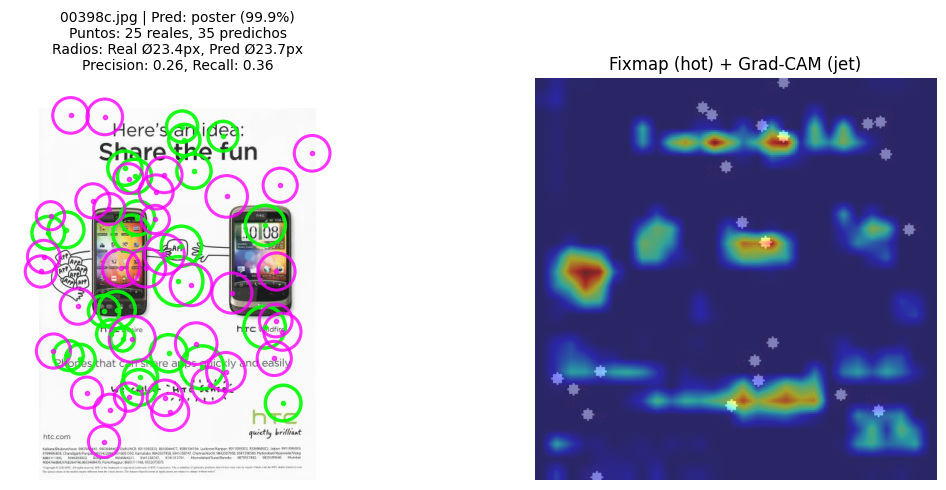

📊 Resultados para 00398c.jpg:
   • Clase predicha: poster (99.9%)
   • Puntos reales: 25, Puntos predichos: 35
   • Radios promedio - Real: 23.4px, Pred: 23.7px
   • Precision: 0.257, Recall: 0.360
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 43.4px
   • Radios reales: min=16, max=33
   • Radios predichos: min=19, max=31

🖼️  Imagen 2/5: 003eb9.png
📏 Aplicando Radio Foveal consistente...
🔍 Predicción - Clase 10: 0, Clase 4: desktop (88.0%)


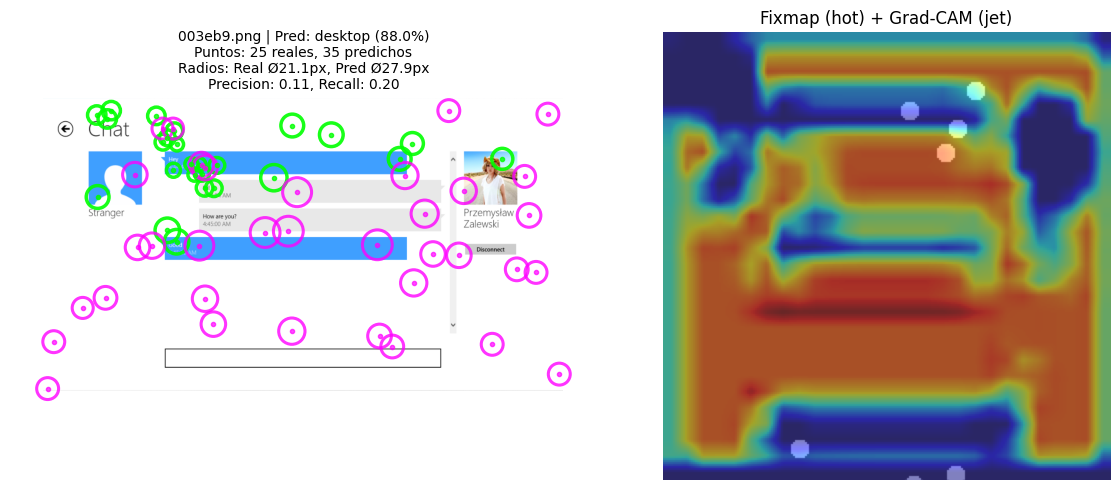

📊 Resultados para 003eb9.png:
   • Clase predicha: desktop (88.0%)
   • Puntos reales: 25, Puntos predichos: 35
   • Radios promedio - Real: 21.1px, Pred: 27.9px
   • Precision: 0.114, Recall: 0.200
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 187.9px
   • Radios reales: min=15, max=30
   • Radios predichos: min=24, max=34

🖼️  Imagen 3/5: 005f83.png
📏 Aplicando Radio Foveal consistente...
🔍 Predicción - Clase 10: 2, Clase 4: poster (99.8%)


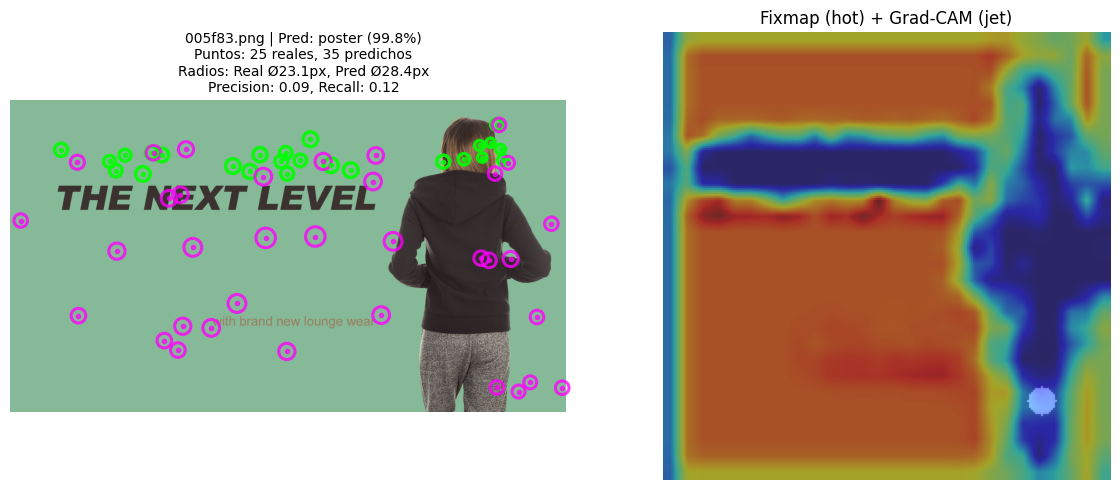

📊 Resultados para 005f83.png:
   • Clase predicha: poster (99.8%)
   • Puntos reales: 25, Puntos predichos: 35
   • Radios promedio - Real: 23.1px, Pred: 28.4px
   • Precision: 0.086, Recall: 0.120
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 361.7px
   • Radios reales: min=17, max=27
   • Radios predichos: min=24, max=36

🖼️  Imagen 4/5: 006450.jpg
📏 Aplicando Radio Foveal consistente...
🔍 Predicción - Clase 10: 1, Clase 4: mobile (100.0%)


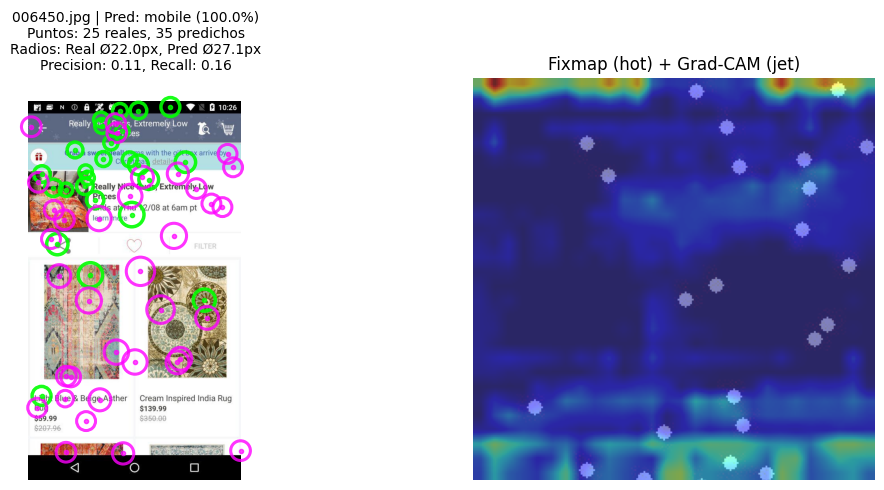

📊 Resultados para 006450.jpg:
   • Clase predicha: mobile (100.0%)
   • Puntos reales: 25, Puntos predichos: 35
   • Radios promedio - Real: 22.0px, Pred: 27.1px
   • Precision: 0.114, Recall: 0.160
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 106.2px
   • Radios reales: min=17, max=31
   • Radios predichos: min=21, max=36

🖼️  Imagen 5/5: 009085.png
📏 Aplicando Radio Foveal consistente...
🔍 Predicción - Clase 10: 3, Clase 4: web (99.8%)


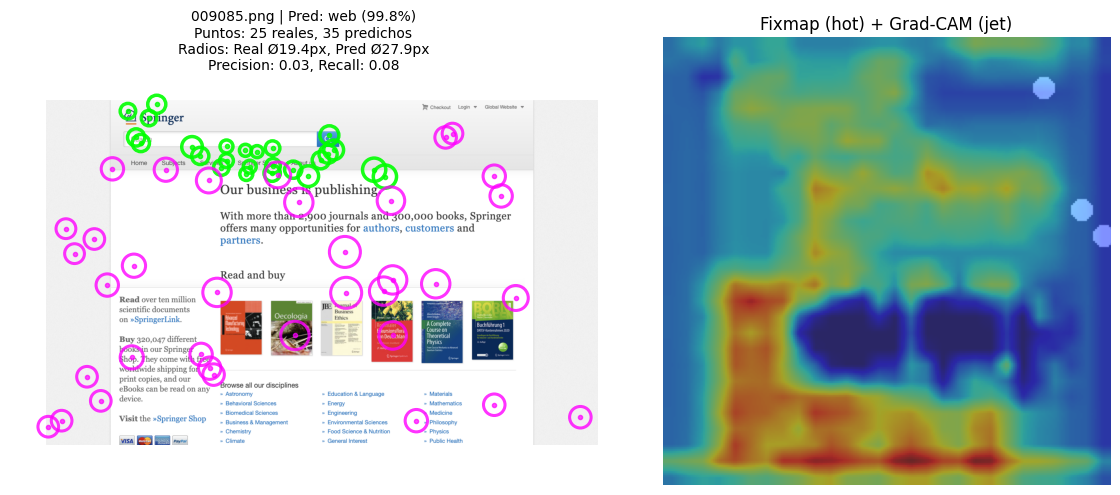

📊 Resultados para 009085.png:
   • Clase predicha: web (99.8%)
   • Puntos reales: 25, Puntos predichos: 35
   • Radios promedio - Real: 19.4px, Pred: 27.9px
   • Precision: 0.029, Recall: 0.080
   • Método de diversificación: adaptive_sampling
   • Distancia promedio: 332.1px
   • Radios reales: min=14, max=27
   • Radios predichos: min=23, max=36


In [10]:
# ==============================================
# Mostrar PUNTOS REALES vs PREDICHOS - RADIO FOVEAL CORREGIDO
# ==============================================
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from scipy import ndimage

# --- Config ---
ROOT = Path("UEyes_dataset")
FIXMAP_DIR = ROOT / "saliency_maps" / "fixmaps_3s"
IMG_DIR = ROOT / "images"

# Mapeo de clases para tu modelo de 10 clases
class_mapping = {
    0: 'desktop',    # Primera clase del modelo -> desktop
    1: 'mobile',     # Segunda clase del modelo -> mobile  
    2: 'poster',     # Tercera clase del modelo -> poster
    3: 'web',        # Cuarta clase del modelo -> web
}
class_names = ['desktop', 'mobile', 'poster', 'web']

# RADIO FOVEAL MEJORADO - CON CONFIGURACIÓN CONSISTENTE
class RadioFoveal:
    def __init__(self, base_radius_real=15, base_radius_pred=18, max_radius=35, min_radius=6):
        # RADIOS MÁS GRANDES Y CONSISTENTES
        self.base_radius_real = base_radius_real
        self.base_radius_pred = base_radius_pred
        self.max_radius = max_radius
        self.min_radius = min_radius
        print(f"🔧 RadioFoveal inicializado - Real: {base_radius_real}px, Pred: {base_radius_pred}px")
    
    def calcular_radio_adaptativo(self, score, es_real=True, densidad_local=1.0, posicion_relativa=0.5):
        """
        Calcula radio adaptativo CONSISTENTE para todas las imágenes
        """
        # USAR RADIO BASE MÁS GRANDE Y CONSISTENTE
        base_radius = self.base_radius_real if es_real else self.base_radius_pred
        
        # Radio base escalado por score (puntos más importantes = más grandes)
        radio_score = base_radius * (0.7 + score * 0.6)  # MÁS CONSISTENTE
        
        # Ajustar por densidad (en áreas densas hacer puntos más pequeños)
        radio_densidad = radio_score * (1.3 - densidad_local * 0.6)  # MÁS TOLERANTE
        
        # Ajustar por posición (puntos centrales ligeramente más grandes)
        radio_posicion = radio_densidad * (1.2 - posicion_relativa * 0.4)  # MÁS VISIBLE
        
        # Aplicar límites CONSISTENTES
        radio_final = np.clip(radio_posicion, self.min_radius, self.max_radius)
        
        return int(radio_final)
    
    def calcular_densidad_local(self, puntos, punto_actual, radio_vision=80):  # RADIO MÁS GRANDE
        """Calcula cuántos puntos hay en un radio alrededor del punto actual"""
        if len(puntos) <= 1:
            return 0.0
        
        x_act, y_act = punto_actual
        puntos_cercanos = 0
        
        for x, y in puntos:
            if x == x_act and y == y_act:
                continue
            distancia = np.sqrt((x - x_act)**2 + (y - y_act)**2)
            if distancia < radio_vision:
                puntos_cercanos += 1
        
        # Normalizar a 0-1 (máximo 8 puntos en el radio considerado como "muy denso")
        return min(puntos_cercanos / 8.0, 1.0)
    
    def calcular_posicion_relativa(self, x, y, width, height):
        """Calcula qué tan cerca está del centro (0=centro, 1=borde)"""
        centro_x, centro_y = width / 2, height / 2
        dist_x = abs(x - centro_x) / (width / 2)
        dist_y = abs(y - centro_y) / (height / 2)
        distancia_al_centro = np.sqrt(dist_x**2 + dist_y**2)
        return min(distancia_al_centro, 1.0)

# INSTANCIAR RADIO FOVEAL CON VALORES MÁS GRANDES
radio_foveal = RadioFoveal(base_radius_real=18, base_radius_pred=22, max_radius=40, min_radius=8)

# [MANTENER TODAS LAS FUNCIONES ANTERIORES HASTA show_real_vs_pred...]

def show_real_vs_pred(image_path: str,
                     k_real=30, k_pred=40,
                     min_dist_real=10, min_dist_pred=8,
                     thr_real=0.15, thr_pred=0.1,
                     sigma_real=1.0, sigma_pred=1.5,
                     radius_metric=25,  # RADIO MÉTRICA MÁS GRANDE
                     diversify_method="adaptive_sampling"):
    """
    Dibuja puntos reales y predichos CON RADIO FOVEAL CONSISTENTE
    """
    img_path = Path(image_path)
    assert img_path.exists(), f"No existe {img_path}"
    
    try:
        pil = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"❌ Error abriendo imagen {img_path.name}: {e}")
        return

    # ----- Reales: desde fixmap -----
    fixmap = load_fixmap_for_image(img_path)
    if fixmap is None:
        print("⚠️ No encontré fixmap para", img_path.name)
        real_peaks = []
    else:
        real_peaks = find_peaks_map(fixmap, k=k_real, min_dist=min_dist_real, 
                                  sigma=sigma_real, thr_rel=thr_real, diversity=True)

    # ----- Predichos: Grad-CAM -----
    x = infer_tfms(pil).unsqueeze(0).to(device)
    x.requires_grad_(True)
    
    target_layer = model.conv4
    gradcam = GradCAM(model, target_layer)
    
    try:
        with torch.no_grad():
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            pred_10_idx = torch.argmax(logits, dim=1).item()
            probs_4 = probs[0, :4]
            pred_4_idx = torch.argmax(probs_4).item()
            pred_cls = class_names[pred_4_idx]
            pred_prob = probs_4[pred_4_idx].item()
            
            print(f"🔍 Predicción - Clase 10: {pred_10_idx}, Clase 4: {pred_cls} ({pred_prob:.1%})")
        
        if pred_10_idx in class_mapping:
            grad_cam_class_idx = pred_10_idx
        else:
            grad_cam_class_idx = pred_4_idx
            
        cam_np, _ = gradcam.generate(x, class_idx=grad_cam_class_idx)

        # Puntos predichos
        rgb_np = np.array(pil)
        H, W, _ = rgb_np.shape
        
        diversified_points = diversify(num_points=k_pred, method=diversify_method, width=W, height=H)
        pred_peaks = [(x, y, 0.7) for x, y in diversified_points]  # SCORE MÁS ALTO PARA MEJOR VISUALIZACIÓN

        # ----- Métricas -----
        real_xy = [(x, y) for (x, y, _) in real_peaks]
        pred_xy = [(x, y) for (x, y, _) in pred_peaks]
        stats = match_stats(pred_xy, real_xy, radius=radius_metric)

        # ----- DIBUJO CON RADIO FOVEAL CONSISTENTE -----
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: Imagen con puntos
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_np)
        plt.axis("off")
        
        # CALCULAR Y APLICAR RADIO FOVEAL A PUNTOS REALES
        real_points_xy = [(x, y) for (x, y, _) in real_peaks]
        real_radios = []
        
        for i, (xv, yv, score) in enumerate(real_peaks):
            densidad = radio_foveal.calcular_densidad_local(real_points_xy, (xv, yv))
            posicion_rel = radio_foveal.calcular_posicion_relativa(xv, yv, W, H)
            
            # CALCULAR RADIO CONSISTENTE PARA REALES
            radio_real = radio_foveal.calcular_radio_adaptativo(
                score, es_real=True, densidad_local=densidad, posicion_relativa=posicion_rel
            )
            real_radios.append(radio_real)
            
            # DIBUJAR PUNTO REAL CON RADIO FOVEAL
            circ = plt.Circle((xv, yv), radius=radio_real, 
                            fill=False, color="lime", linewidth=2.5, alpha=0.9)
            plt.gca().add_patch(circ)
            
            # AÑADIR PUNTO CENTRAL PARA MEJOR VISIBILIDAD
            plt.plot(xv, yv, 'o', color='lime', markersize=3, alpha=0.8)

        # CALCULAR Y APLICAR RADIO FOVEAL A PUNTOS PREDICHOS
        pred_points_xy = [(x, y) for (x, y, _) in pred_peaks]
        pred_radios = []
        
        for i, (xv, yv, score) in enumerate(pred_peaks):
            densidad = radio_foveal.calcular_densidad_local(pred_points_xy, (xv, yv))
            posicion_rel = radio_foveal.calcular_posicion_relativa(xv, yv, W, H)
            
            # CALCULAR RADIO CONSISTENTE PARA PREDICHOS
            radio_pred = radio_foveal.calcular_radio_adaptativo(
                score, es_real=False, densidad_local=densidad, posicion_relativa=posicion_rel
            )
            pred_radios.append(radio_pred)
            
            # DIBUJAR PUNTO PREDICHO CON RADIO FOVEAL
            circ = plt.Circle((xv, yv), radius=radio_pred, 
                            fill=False, color="magenta", linewidth=2.2, alpha=0.8)
            plt.gca().add_patch(circ)
            
            # AÑADIR PUNTO CENTRAL PARA MEJOR VISIBILIDAD
            plt.plot(xv, yv, 'o', color='magenta', markersize=3, alpha=0.7)

        # INFORMACIÓN DE RADIOS EN EL TÍTULO
        radio_promedio_real = np.mean(real_radios) if real_radios else 0
        radio_promedio_pred = np.mean(pred_radios) if pred_radios else 0
        
        plt.title(f"{img_path.name} | Pred: {pred_cls} ({pred_prob:.1%})\n"
                  f"Puntos: {len(real_peaks)} reales, {len(pred_peaks)} predichos\n"
                  f"Radios: Real Ø{radio_promedio_real:.1f}px, Pred Ø{radio_promedio_pred:.1f}px\n"
                  f"Precision: {stats['p']:.2f}, Recall: {stats['r']:.2f}",
                  fontsize=10)

        # Subplot 2: Mapas de calor
        plt.subplot(1, 2, 2)
        if fixmap is not None:
            plt.imshow(fixmap, cmap="hot", alpha=0.7)
            plt.title("Fixmap (hot) + Grad-CAM (jet)")
        else:
            plt.title("Grad-CAM (predicho)")
        plt.imshow(cam_np, cmap="jet", alpha=0.5)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # INFORMACIÓN DETALLADA EN CONSOLA
        print(f"📊 Resultados para {img_path.name}:")
        print(f"   • Clase predicha: {pred_cls} ({pred_prob:.1%})")
        print(f"   • Puntos reales: {len(real_peaks)}, Puntos predichos: {len(pred_peaks)}")
        print(f"   • Radios promedio - Real: {radio_promedio_real:.1f}px, Pred: {radio_promedio_pred:.1f}px")
        print(f"   • Precision: {stats['p']:.3f}, Recall: {stats['r']:.3f}")
        print(f"   • Método de diversificación: {diversify_method}")
        if stats['d_pred2real'] is not None:
            print(f"   • Distancia promedio: {stats['d_pred2real']:.1f}px")
            
        # VERIFICACIÓN DE RADIOS
        if real_radios:
            print(f"   • Radios reales: min={min(real_radios)}, max={max(real_radios)}")
        if pred_radios:
            print(f"   • Radios predichos: min={min(pred_radios)}, max={max(pred_radios)}")
            
    except Exception as e:
        print(f"❌ Error durante Grad-CAM: {e}")
        import traceback
        traceback.print_exc()

# ---------- USO MEJORADO ----------
print("🎯 Iniciando análisis con RADIO FOVEAL CONSISTENTE...")
print(f"🔧 Configuración RadioFoveal:")
print(f"   • Base real: {radio_foveal.base_radius_real}px")
print(f"   • Base pred: {radio_foveal.base_radius_pred}px")
print(f"   • Máximo: {radio_foveal.max_radius}px")
print(f"   • Mínimo: {radio_foveal.min_radius}px")

# Verificar que el modelo esté cargado
if 'model' not in globals():
    print("❌ Error: El modelo no está cargado. Ejecuta primero la carga del modelo.")
else:
    print(f"✅ Modelo cargado correctamente para {len(class_names)} clases: {class_names}")

# Listar imágenes disponibles
available_images = [img for img in IMG_DIR.glob("*") 
                   if img.is_file() and img.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp'}]

print(f"📁 Se encontraron {len(available_images)} imágenes válidas")

if available_images:
    # Probar con TODAS las imágenes para verificar consistencia
    test_images = available_images[:5]  # Probar con más imágenes
    print(f"🔍 Procesando {len(test_images)} imágenes para verificar consistencia...")
    
    for i, test_image in enumerate(test_images, 1):
        print(f"\n{'='*60}")
        print(f"🖼️  Imagen {i}/{len(test_images)}: {test_image.name}")
        print(f"📏 Aplicando Radio Foveal consistente...")
        
        # Usar solo el mejor método para consistencia
        show_real_vs_pred(str(test_image), k_real=25, k_pred=35, radius_metric=25, diversify_method="adaptive_sampling")
else:
    print("⚠️ No se encontraron imágenes válidas en el directorio")